# Retail Credit Risk Project

In [1]:
# import packages
from collections import Counter
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import math
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Data Cleaning and Feature Engineering

In [2]:
# import dataset
df = pd.read_csv('../data/mmf_data2.csv')
print('number of original features: ' + str(len(df.columns)))
df.head()

number of original features: 562


,tu_seq_id,TIME_KEY,CUSTTYPE,HIGHRISK,WIDELYHD,STARTUP,TERMCUST,PDLCUST,OLCUST,VISACUST,PROFTYPE,BSL_SB_CUST,BSL_CUST_AIRB,HasAIRBProduct,Widely_Held,NFP,Out_of_Country,SPP_Group_1,SPP_Group_2,Automotive_New_Cars_Dealer,BOBB,OPFBCUST,DOCTOR_DENTIST_IND,RESTAURANT_IND,TRUCKING_IND,RESTAURANT_OR_TRUCKING_IND,SPP_LISTED_IND,SPP_TARGETED_IND,SPP_LISTED_OR_TARGETED_IND,TBSAT01,TBSAT103S,TBSAT33A,TBSAT34B,TBSBC104S,TBSBC33S,TBSBC35S,TBSBC97A,TBSBR34S,TBSG001B,TBSG059S,TBSG202A,TBSG302S,TBSRE24S,TBSRE29S,TBSRE30S,TBSRE36S,TBSRN33S,TBSRN34S,GO170,NA11,CVPRAEP112,CVPRAGG102,CVPRAGG501,CVPRAGG512,CVPRAGG519,CVPRAGG905,CVPRAGG907,CVPRAGG910,CVPRRVLR01,CVPRRVLR07,CVPRTPR103,CVPRTPR212,CVPRTPR301,CVPRTPR312,CVPRTRV04,CVPRTRV12,CVPRTRV14,CVPRWALSHR01,CVPRWALSHR02,cust_any_nsf,cust_card_max_util_6mos,cust_max_dlq_3mos,cust_rev_max_dlq_6mos,cust_sum_dlq_24mos,cust_sum_dlqdays_12mos,d2dbalp_avg_l6m,agri_cust,TBSSC100,CVPRRVLR29,GO138,Go129_yymm,dda_max_open_date,dda_max_Last_Dep_Date,dda_sum_ABM_Dep_Txn_Cnt,dda_sum_Acc_Cr_Bal,dda_sum_Acc_Daily_OD_Int,dda_sum_Acc_Db_Bal,dda_max_Avg_Cr_Bal,dda_max_Avg_Cr_Bal_Prev,dda_min_Avg_Db_Bal,dda_sum_Chargebacks,dda_sum_Dep_Txn_Cnt,dda_sum_Limit,dda_max_Max_Mthly_Bal,dda_min_Min_Mthly_Bal,dda_sum_Night_Dep_Txn_Cnt,dda_sum_OD_Charges,dda_sum_OL_Days,dda_sum_OS_Bal,dda_sum_Qtr_NSF,dda_sum_Qtr_NSF_Prev,dda_sum_Qtr_NSF_Prev_2,dda_sum_Qtr_NSF_Prev_3,dda_sum_Ttl_Dep_Prev,dda_sum_Ttl_Dep_Prev_2,dda_sum_Ttl_Dep_Prev_3,dda_avg_av_db_bal,dda_time_since_open_mos,dda_max_mthly_av_bal,dda_min_mthly_av_bal,dda_av_bal,dda_time_since_dep_days,dda_avg_dly_dep_amt_L90,dda_ratio_cr_bal,lease_tot_osbal,max_ls_age,max_ls_any_bad_12mos,max_ls_any_bad_24mos,max_ls_any_bad_3mos,max_ls_any_bad_6mos,max_ls_any_def_12mos,max_ls_any_def_24mos,max_ls_any_def_3mos,max_ls_any_def_6mos,max_ls_max_dlq_12mos,max_ls_max_dlq_24mos,max_ls_max_dlq_3mos,max_ls_max_dlq_6mos,max_ls_max_dlqdays_12mos,max_ls_max_dlqdays_24mos,max_ls_max_dlqdays_3mos,max_ls_max_dlqdays_6mos,max_ls_months_default,max_ls_num_bad_12mos,max_ls_num_bad_24mos,max_ls_num_bad_3mos,max_ls_num_bad_6mos,max_ls_num_def_12mos,max_ls_num_def_24mos,max_ls_num_def_3mos,max_ls_num_def_6mos,max_ls_num_dlq_12mos,max_ls_num_dlq_24mos,max_ls_num_dlq_3mos,max_ls_num_dlq_6mos,max_ls_num_dlqdays_12mos,max_ls_num_dlqdays_24mos,max_ls_num_dlqdays_3mos,max_ls_num_dlqdays_6mos,mo_tot_osbal,mo_tot_auth_amt,max_mo_DELQ_DAYS,max_mo_age,max_mo_any_bad_12mos,max_mo_any_bad_24mos,max_mo_any_bad_3mos,max_mo_any_bad_6mos,max_mo_any_def_12mos,max_mo_any_def_24mos,max_mo_any_def_3mos,max_mo_any_def_6mos,max_mo_max_dlq_12mos,max_mo_max_dlq_24mos,max_mo_max_dlq_3mos,max_mo_max_dlq_6mos,max_mo_max_dlqdays_12mos,max_mo_max_dlqdays_24mos,max_mo_max_dlqdays_3mos,max_mo_max_dlqdays_6mos,max_mo_num_bad_12mos,max_mo_num_bad_24mos,max_mo_num_bad_3mos,max_mo_num_bad_6mos,max_mo_num_def_12mos,max_mo_num_def_24mos,max_mo_num_def_3mos,max_mo_num_def_6mos,max_mo_num_dlq_12mos,max_mo_num_dlq_24mos,max_mo_num_dlq_3mos,max_mo_num_dlq_6mos,max_mo_num_dlqdays_12mos,max_mo_num_dlqdays_24mos,max_mo_num_dlqdays_3mos,max_mo_num_dlqdays_6mos,max_mo_remainamort,mo_pct_tot_utilz,min_oll_avg_ytd_bal,max_oll__dlq_times,max_oll__days_late,tot_oll_limit,tot_oll_os_bal,max_oll_any_def_24mos,max_oll_any_def_12mos,max_oll_any_def_6mos,max_oll_any_def_3mos,max_oll_any_bad_24mos,max_oll_any_bad_12mos,max_oll_any_bad_6mos,max_oll_any_bad_3mos,max_oll_num_def_24mos,max_oll_num_def_12mos,max_oll_num_def_6mos,max_oll_num_def_3mos,max_oll_num_bad_24mos,max_oll_num_bad_12mos,max_oll_num_bad_6mos,max_oll_num_bad_3mos,max_oll_num_dlq_24mos,max_oll_num_dlq_12mos,max_oll_num_dlq_6mos,max_oll_num_dlq_3mos,max_oll_num_overlimit_24mos,max_oll_num_overlimit_12mos,max_oll_num_overlimit_6mos,max_oll_num_overlimit_3mos,max_oll_term_max_dlq_24mos,max_oll_term_max_dlq_12mos,max_oll_term_max_dlq_6mos,max_oll_term_max_dlq_3mos,max_oll_line_max_dlq_24mos,max_oll_line_max_dlq_12mos,max_oll_line_max_dlq_6mos,max_oll_line_max_dlq_3mos,max_oll_age,max_oll_max_dlqt

In [3]:
# check datatype
print(df.dtypes)

tu_seq_id                         object
TIME_KEY                           int64
CUSTTYPE                          object
HIGHRISK                          object
WIDELYHD                          object
STARTUP                           object
TERMCUST                          object
PDLCUST                           object
OLCUST                            object
VISACUST                          object
PROFTYPE                          object
BSL_SB_CUST                       object
BSL_CUST_AIRB                     object
HasAIRBProduct                    object
Widely_Held                       object
NFP                               object
Out_of_Country                    object
SPP_Group_1                       object
SPP_Group_2                       object
Automotive_New_Cars_Dealer        object
BOBB                              object
OPFBCUST                          object
DOCTOR_DENTIST_IND                object
RESTAURANT_IND                    object
TRUCKING_IND    

- tu_seq_id: Customer ID
- TIME_KEY(numeric categorical): 15076 = Jan 2014, 15196 = Apr 2014, 15316 = July 2014, 15436 = Oct 2014
- 'CUSTTYPE' - 'SPP_LISTED_OR_TARGETED_IND'：all text categorical variables
- All variables after are numerical (some are categorical variables)
- 't1' to 't12' should be used to create the response variable
- 'GRP_ALL2320' - 'WOE_max_ks_num_dlqdays_12mos' contain WOE calculations for many variables....
- credit and debit variables are used to create new explanatory variables
- 4 benchmark variables at the end that might need to be separated out


In [4]:
# Create new columns indicating the months difference between the latest depost/account open date and the 'TIME_KEY' date

# -- function to standardize the 'TIME_KEY' column
def time_key(column):
    map_time_key  = {15076:201401, 15196:201404, 15316:201407, 15436:201410}
    return column.map(map_time_key)

# -- function to convert integer date column to datetime type and calculate the difference from the date to the 
# 'TIME_KEY' date --
def date_diff(df, column):
    df[column] = pd.to_datetime(df[column], format= '%Y%m')
    # calculate the difference in months and add to a new column, drop the original column
    df['mths_from_' + column] = round(pd.to_numeric((df['TIME_KEY'] - df[column]) / np.timedelta64(1, 'M')))
    df.drop(columns = [column], axis=1)

# standardize the 'Time_Key' column
df_time_key = time_key(df['TIME_KEY'])
df_time_key = pd.to_datetime(df_time_key, format= '%Y%m')
df['TIME_KEY'] = df_time_key

# deal with other date columns
df['Go129_yymm'] = date_diff(df, 'Go129_yymm')
df['dda_max_open_date'] = date_diff(df, 'dda_max_open_date')
df['dda_max_Last_Dep_Date'] = date_diff(df, 'dda_max_Last_Dep_Date')
# drop the 'mths_from_Go129_yymm' column b/c it only has the value 6. No effect on the modeling later
df.drop(columns = ['mths_from_Go129_yymm'], inplace = True)

In [5]:
# create new variables based on the credit and debit variables using credit to debit ratio
df['credit_to_debit_curr'] = df['credit_curr'] / df['debit_curr']
for i in range(12):
    df['credit_to_debit_prev' + str(i+1)] = df['credit_prev' + str(i+1)] / df['debit_prev' + str(i+1)]

# create bins for the credit to debit variables --
bins = [0, 1, 1.2, 1.4, 1.6, 2, 100]
labels = [0,1,2,3,4,5]
df['credit_to_debit_curr'] = pd.cut(df['credit_to_debit_curr'], bins=bins, labels=labels)
for i in range(12):
    df['credit_to_debit_prev' + str(i+1)] = pd.cut(df['credit_to_debit_prev' + str(i+1)], bins=bins, labels=labels)

# drop the original credit and debit variables, as well as the 13 liability columns
index = df.columns.get_loc('debit_curr')
df.drop(df.columns[index:index+26], axis=1, inplace=True)

# check the 'liability_risk' column
df['credit_to_debit_curr']

0         0
1         0
2         0
3         0
4         1
5         5
6         0
7         5
8         0
9         5
10        0
11        0
12        5
13        3
14        5
15        0
16        0
17        1
18        0
19        2
20        0
21        0
22        5
23        5
24        0
25        0
26        0
27        0
28        5
29        0
30        0
31        0
32        1
33        5
34        3
35        0
36        0
37        0
38        0
39        3
40        0
41        0
42        0
43        0
44        0
45        4
46        0
47        0
48        0
49        0
50        0
51        0
52        2
53        0
54        5
55        0
56        2
57        3
58        5
59        5
60        0
61        1
62        5
63        0
64        5
65      NaN
66        5
67        0
68        4
69        3
70        5
71        0
72      NaN
73        0
74        5
75        5
76        0
77        5
78        1
79        0
80        5
81        0
82        0
83  

If credit-to-debit ratio is way larger than 1, that means the client has large liability. So larger bin the 'credit_to_debit_curr' variable indicates larger liability for the current month. The logic applis to the other 12 credit-to-debit ratios features

In [6]:
# delete widely held customers and deceased customers
n_pop = df.shape[0]
index = (df['WIDELYHD'] == 'Y') | (df['deceased'] == 1)
df = df.drop(df.index[index])
print('total number of population size: ' + str(n_pop))
print('population size after exclusion: ' + str(len(df.index)))
print('number of exclusions: ' + str(n_pop-len(df.index)))

total number of population size: 9028
population size after exclusion: 9012
number of exclusions: 16


In [7]:
# extract the 4 benchmark variables

df_benchmark = df[['benchmark1', 'benchmark2', 'benchmark3', 'benchmark4']]
df_benchmark.reset_index(drop=True, inplace=True)

df.drop(columns = ['benchmark1', 'benchmark2', 'benchmark3', 'benchmark4'], axis=1, inplace=True)
# extract the 'TIME_KEY' variable
df_timekey = df['TIME_KEY']
df_timekey.reset_index(drop=True, inplace=True)

df.drop(columns = ['TIME_KEY'], inplace = True)


We have 'df_benchmark' and 'df_timekey' that need be used later

- Create the response variable \
Observed that if t_i is 1, then t_i, t_i+1,..., t_12 are all 1


In [8]:
# Create response variable
# the target variable is the t12
df['default_risk'] = df['t12']

# Calculate the default rate for the entire population as well as for each observation point
a = {}
b = {}
for i in range(12):
    a["pct_default_t{0}".format(i+1)] = (df['t' + str(i+1)] != 0).sum() / df.shape[0]
    b["count_default_t{0}".format(i+1)] = (df['t' + str(i+1)] != 0).sum()
a,b

({'pct_default_t1': 0.009764758100310697,
  'pct_default_t2': 0.019529516200621395,
  'pct_default_t3': 0.02785175321793165,
  'pct_default_t4': 0.03595206391478029,
  'pct_default_t5': 0.04360852197070573,
  'pct_default_t6': 0.050821127385707945,
  'pct_default_t7': 0.05770084332001776,
  'pct_default_t8': 0.06657789613848203,
  'pct_default_t9': 0.07334664891256103,
  'pct_default_t10': 0.08288948069241012,
  'pct_default_t11': 0.091988459831336,
  'pct_default_t12': 0.09986684420772303},
 {'count_default_t1': 88,
  'count_default_t2': 176,
  'count_default_t3': 251,
  'count_default_t4': 324,
  'count_default_t5': 393,
  'count_default_t6': 458,
  'count_default_t7': 520,
  'count_default_t8': 600,
  'count_default_t9': 661,
  'count_default_t10': 747,
  'count_default_t11': 829,
  'count_default_t12': 900})

The target variable is 'default_risk' is 't12', which indicates the default flag at the 12th month after observation point.

In [9]:
# drop the original t1 - t12 variables
index = df.columns.get_loc('t1')
df.drop(df.columns[index:index+12], axis=1, inplace=True)
df['default_risk'].head(10) # the response variable that indicates the default rate

0    0
1    0
2    0
3    0
4    0
5    0
6    1
7    1
8    0
9    0
Name: default_risk, dtype: int64

In [10]:
# Check for missing data
NAN = [(c,df[c].isnull().mean().round(4)*100) for c in df]
NAN = pd.DataFrame(NAN, columns=['column_name','percentage missing(%)'])
print(NAN)  # No column has a significant amount of missing values

                         column_name  percentage missing(%)
0                          tu_seq_id                   0.00
1                           CUSTTYPE                   0.00
2                           HIGHRISK                   0.00
3                           WIDELYHD                   0.00
4                            STARTUP                   0.00
5                           TERMCUST                   0.00
6                            PDLCUST                   0.00
7                             OLCUST                   0.00
8                           VISACUST                   0.00
9                           PROFTYPE                   0.00
10                       BSL_SB_CUST                   0.00
11                     BSL_CUST_AIRB                   0.00
12                    HasAIRBProduct                   0.00
13                       Widely_Held                   0.01
14                               NFP                   0.00
15                    Out_of_Country    

Note that there are no missing values for all WOE features. So we extract them in 'df_WOE_sel' now for later calculations.

In [11]:
df_WOE_sel = df.loc[:, df.columns.str.contains("WOE")]
df_WOE_sel.reset_index(drop=True, inplace=True)

In [12]:
# drop columns that have more than 80% of the data missing
index = NAN.iloc[:,1] >= 80
df = df.drop(NAN.iloc[:,0][index], axis=1)
# drop the customer id variable
df = df.drop(['tu_seq_id'], axis=1)
print('number of features left: ' + str(len(df.columns)))

number of features left: 405


In [13]:
# one-hot encoding for text categorical variables
df_text = df.select_dtypes(include=['object'])
df_text_dummies = pd.get_dummies(df_text)
df_text_dummies.head()

,CUSTTYPE_B,CUSTTYPE_O,CUSTTYPE_T,HIGHRISK_N,HIGHRISK_Y,WIDELYHD_N,STARTUP_N,STARTUP_Y,TERMCUST_N,TERMCUST_Y,PDLCUST_N,OLCUST_N,OLCUST_Y,VISACUST_N,VISACUST_Y,PROFTYPE_C,BSL_SB_CUST_Y,BSL_CUST_AIRB_Y,HasAIRBProduct_Y,Widely_Held_N,NFP_N,Out_of_Country_N,Out_of_Country_Y,SPP_Group_1_N,SPP_Group_1_Y,SPP_Group_2_N,SPP_Group_2_Y,Automotive_New_Cars_Dealer_N,OPFBCUST_N,DOCTOR_DENTIST_IND_N,DOCTOR_DENTIST_IND_Y,RESTAURANT_IND_N,RESTAURANT_IND_Y,TRUCKING_IND_N,TRUCKING_IND_Y,RESTAURANT_OR_TRUCKING_IND_N,RESTAURANT_OR_TRUCKING_IND_Y,SPP_LISTED_IND_N,SPP_LISTED_IND_Y,SPP_TARGETED_IND_N,SPP_TARGETED_IND_Y,SPP_LISTED_OR_TARGETED_IND_N,SPP_LISTED_OR_TARGETED_IND_Y
0,0,1,0,1,0,1,1,0,1,0,1,1,0,0,1,1,1,1,1,1,1,1,0,1,0,1,0,1,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0
1,0,1,0,1,0,1,1,0,1,0,1,1,0,1,0,1,1,1,1,1,1,1,0,0,1,1,0,1,1,0,1,1,0,1,0,1,0,1,0,0,1,0,1
2,0,1,0,1,0,1,1,0,1,0,1,1,0,0,1,1,1,1,1,1,1,1,0,1,0,1,0,1,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0
3,0,1,0,1,0,1,1,0,1,0,1,1,0,1,0,1,1,1,1,1,1,1,0,1,0,1,0,1,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0
4,0,1,0,1,0,1,1,0,1,0,1,1,0,0,1,1,1,1,1,1,1,1,0,1,0,1,0,1,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0


In [14]:
# drop the old text categorical variables and append the newly created numeric categorical ones
df.drop(df.columns[0:26], axis = 1, inplace = True)
df = pd.concat([df, df_text_dummies], axis=1)
df.head()

,TBSAT01,TBSAT103S,TBSAT33A,TBSAT34B,TBSBC104S,TBSBC33S,TBSBC35S,TBSBC97A,TBSBR34S,TBSG001B,TBSG059S,TBSG202A,TBSG302S,TBSRE24S,TBSRE29S,TBSRE30S,TBSRE36S,TBSRN33S,TBSRN34S,GO170,NA11,CVPRAEP112,CVPRAGG102,CVPRAGG501,CVPRAGG512,CVPRAGG519,CVPRAGG905,CVPRAGG907,CVPRAGG910,CVPRRVLR01,CVPRRVLR07,CVPRTPR103,CVPRTPR212,CVPRTPR301,CVPRTPR312,CVPRTRV04,CVPRTRV12,CVPRTRV14,CVPRWALSHR01,CVPRWALSHR02,cust_any_nsf,cust_card_max_util_6mos,cust_max_dlq_3mos,cust_rev_max_dlq_6mos,cust_sum_dlq_24mos,cust_sum_dlqdays_12mos,d2dbalp_avg_l6m,agri_cust,TBSSC100,CVPRRVLR29,GO138,dda_sum_ABM_Dep_Txn_Cnt,dda_sum_Acc_Cr_Bal,dda_sum_Acc_Daily_OD_Int,dda_sum_Acc_Db_Bal,dda_max_Avg_Cr_Bal,dda_max_Avg_Cr_Bal_Prev,dda_min_Avg_Db_Bal,dda_sum_Chargebacks,dda_sum_Dep_Txn_Cnt,dda_sum_Limit,dda_max_Max_Mthly_Bal,dda_min_Min_Mthly_Bal,dda_sum_Night_Dep_Txn_Cnt,dda_sum_OD_Charges,dda_sum_OL_Days,dda_sum_OS_Bal,dda_sum_Qtr_NSF,dda_sum_Qtr_NSF_Prev,dda_sum_Qtr_NSF_Prev_2,dda_sum_Qtr_NSF_Prev_3,dda_sum_Ttl_Dep_Prev,dda_sum_Ttl_Dep_Prev_2,dda_sum_Ttl_Dep_Prev_3,dda_avg_av_db_bal,dda_time_since_open_mos,dda_max_mthly_av_bal,dda_min_mthly_av_bal,dda_av_bal,dda_time_since_dep_days,dda_avg_dly_dep_amt_L90,dda_ratio_cr_bal,ks_tot_limit,ks_tot_osbal,max_ks_any_def_24mos,max_ks_any_def_12mos,max_ks_any_def_6mos,max_ks_any_def_3mos,max_ks_any_bad_24mos,max_ks_any_bad_12mos,max_ks_any_bad_6mos,max_ks_any_bad_3mos,max_ks_max_dlqdays_24mos,max_ks_max_dlqdays_12mos,max_ks_max_dlqdays_6mos,max_ks_max_dlqdays_3mos,max_ks_num_def_24mos,max_ks_num_def_12mos,max_ks_num_def_6mos,max_ks_num_def_3mos,max_ks_num_bad_24mos,max_ks_num_bad_12mos,max_ks_num_bad_6mos,max_ks_num_bad_3mos,max_ks_num_dlq_24mos,max_ks_num_dlq_12mos,max_ks_num_dlq_6mos,max_ks_num_dlq_3mos,max_ks_num_dlqdays_24mos,max_ks_num_dlqdays_12mos,max_ks_num_dlqdays_6mos,max_ks_num_dlqdays_3mos,max_ks_num_overlimit_24mos,max_ks_num_overlimit_12mos,max_ks_num_overlimit_6mos,max_ks_num_overlimit_3mos,max_ks_max_dlq_24mos,max_ks_max_dlq_12mos,max_ks_max_dlq_6mos,max_ks_max_dlq_3mos,max_ks_age,max_ks_max_util_24mos,max_ks_max_util_12mos,max_ks_max_util_6mos,max_ks_max_util_3mos,pct_ks_util,ALL2320,ALL2326,ALL2327,ALL2350,ALL2358,ALL2380,ALL2700,ALL6160,ALL6200,ALL6230,ALL7330,ALL7938,ALL8150,ALL8160,ALL8358,BCA2358,BCA2380,BCA5030,BCC3510,BCC3515,BCC5620,BCC5830,BCC6200,BCC6280,BCC7110,BCC7120,BRC8158,HLC5030,HLC7110,IQT9410,IQT9420,REV2320,REV2327,REV2328,REV2350,REV3423,REV5020,REV5030,REV5620,REV8153,GRP_ALL2320,WOE_ALL2320,GRP_ALL2326,WOE_ALL2326,GRP_ALL2327,WOE_ALL2327,GRP_ALL2350,WOE_ALL2350,GRP_ALL2358,WOE_ALL2358,GRP_ALL2380,WOE_ALL2380,GRP_ALL2700,WOE_ALL2700,GRP_ALL6160,WOE_ALL6160,GRP_ALL6200,WOE_ALL6200,GRP_ALL6230,WOE_ALL6230,GRP_ALL7330,WOE_ALL7330,GRP_ALL7938,WOE_ALL7938,GRP_ALL8150,WOE_ALL8150,GRP_ALL8160,WOE_ALL8160,GRP_ALL8358,WOE_ALL8358,GRP_BCA2358,WOE_BCA2358,GRP_BCA2380,WOE_BCA2380,GRP_BCA5030,WOE_BCA5030,GRP_BCC3510,WOE_BCC3510,GRP_BCC3515,WOE_BCC3515,GRP_BCC5620,WOE_BCC5620,GRP_BCC5830,WOE_BCC5830,GRP_BCC6200,WOE_BCC6200,GRP_BCC6280,WOE_BCC6280,GRP_BCC7110,WOE_BCC7110,GRP_BCC7120,WOE_BCC7120,GRP_BRC8158,WOE_BRC8158,GRP_CVPRAEP112,WOE_CVPRAEP112,GRP_CVPRAGG102,WOE_CVPRAGG102,GRP_CVPRAGG501,WOE_CVPRAGG501,GRP_CVPRAGG512,WOE_CVPRAGG512,GRP_CVPRAGG519,WOE_CVPRAGG519,GRP_CVPRAGG905,WOE_CVPRAGG905,GRP_CVPRAGG907,WOE_CVPRAGG907,GRP_CVPRAGG910,WOE_CVPRAGG910,GRP_CVPRRVLR01,WOE_CVPRRVLR01,GRP_CVPRRVLR07,WOE_CVPRRVLR07,GRP_CVPRTPR103,WOE_CVPRTPR103,GRP_CVPRTPR212,WOE_CVPRTPR212,GRP_CVPRTPR301,WOE_CVPRTPR301,GRP_CVPRTPR312,WOE_CVPRTPR312,GRP_CVPRTRV04,WOE_CVPRTRV04,GRP_CVPRTRV12,WOE_CVPRTRV12,GRP_CVPRTRV14,WOE_CVPRTRV14,GRP_CVPRWALSHR01,WOE_CVPRWALSHR01,GRP_CVPRWALSHR02,WOE_CVPRWALSHR02,GRP_CVSC100,WOE_CVSC100,GRP_CVSC110,WOE_CVSC110,GRP_GO170,WOE_GO170,GRP_HLC5030,WOE_HLC5030,GRP_HLC7110,WOE_HLC7110,GRP_IQT9410,WOE_IQT9410,GRP_IQT9420,WOE_IQT9420,GRP_NA11,WOE_NA11,GRP_PD_Total_Scorecard_Points,WOE_PD_Total_Scorecard_Points,GRP_REV2320,WOE_REV2320,GRP_REV2327,WOE_REV2327,GRP_REV2328,WOE_REV2328,GRP_REV2350,WOE_REV

Now all variables are numbers except for missing values

In [15]:
df.nunique()

TBSAT01                              22
TBSAT103S                            19
TBSAT33A                           4903
TBSAT34B                            118
TBSBC104S                           120
TBSBC33S                           2885
TBSBC35S                           2825
TBSBC97A                           2887
TBSBR34S                            122
TBSG001B                             20
TBSG059S                              7
TBSG202A                           4503
TBSG302S                             12
TBSRE24S                             16
TBSRE29S                             15
TBSRE30S                             23
TBSRE36S                             29
TBSRN33S                           2211
TBSRN34S                            122
GO170                               408
NA11                                328
CVPRAEP112                         4768
CVPRAGG102                         8038
CVPRAGG501                         6070
CVPRAGG512                         5912


In [16]:
# split between numeric and categorical features
# Assume features with less or equal to 15 unique values are categorical. Others are all numeric features
index_categ = df.nunique()<=15
index_numeric = df.nunique()>15
df_categ = df[df.columns[index_categ]]
df_numeric = df[df.columns[index_numeric]]
df_numeric.head()

,TBSAT01,TBSAT103S,TBSAT33A,TBSAT34B,TBSBC104S,TBSBC33S,TBSBC35S,TBSBC97A,TBSBR34S,TBSG001B,TBSG202A,TBSRE24S,TBSRE30S,TBSRE36S,TBSRN33S,TBSRN34S,GO170,NA11,CVPRAEP112,CVPRAGG102,CVPRAGG501,CVPRAGG512,CVPRAGG519,CVPRAGG905,CVPRAGG907,CVPRAGG910,CVPRRVLR01,CVPRTPR103,CVPRTPR212,CVPRTPR301,CVPRTPR312,CVPRTRV04,CVPRTRV12,CVPRTRV14,cust_card_max_util_6mos,cust_sum_dlq_24mos,d2dbalp_avg_l6m,TBSSC100,CVPRRVLR29,dda_sum_Acc_Cr_Bal,dda_sum_Acc_Daily_OD_Int,dda_sum_Acc_Db_Bal,dda_max_Avg_Cr_Bal,dda_max_Avg_Cr_Bal_Prev,dda_min_Avg_Db_Bal,dda_sum_Limit,dda_max_Max_Mthly_Bal,dda_min_Min_Mthly_Bal,dda_sum_OD_Charges,dda_sum_OS_Bal,dda_sum_Ttl_Dep_Prev,dda_sum_Ttl_Dep_Prev_2,dda_sum_Ttl_Dep_Prev_3,dda_avg_av_db_bal,dda_max_mthly_av_bal,dda_min_mthly_av_bal,dda_av_bal,dda_avg_dly_dep_amt_L90,dda_ratio_cr_bal,ks_tot_limit,ks_tot_osbal,max_ks_max_dlqdays_24mos,max_ks_max_dlqdays_12mos,max_ks_max_dlqdays_6mos,max_ks_max_dlqdays_3mos,max_ks_num_dlqdays_24mos,max_ks_num_overlimit_24mos,max_ks_age,max_ks_max_util_24mos,max_ks_max_util_12mos,max_ks_max_util_6mos,max_ks_max_util_3mos,pct_ks_util,ALL2320,ALL7330,ALL7938,ALL8150,ALL8160,ALL8358,BCA5030,BCC3510,BCC3515,BCC5620,BCC5830,BCC7110,BCC7120,BRC8158,HLC5030,HLC7110,IQT9410,IQT9420,REV2320,REV2328,REV5020,REV5030,REV5620,REV8153,mths_from_dda_max_open_date,mths_from_dda_max_Last_Dep_Date
0,-7,-7,-7,-7,-7,-7,-7,-7,-7,-7,-7,-7,-7,-7,-7,-7,844.0,790.0,0.0,5366.0,1356.0,967.0,340.0,7.87,2463.0,9.85,0.0,0.00,0.00,0.00,0.00,2.0,-2.0,-2.0,0.00,0,8814.435000,0,1356.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30000.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,128.0,0.61,0.27,0.00,0.00,0.00000,1.0,93.0,75.0,7.0,9996.0,9996.0,1356.0,1.0,1.0,33644.0,27.0,4.0,5.0,9996.0,999999998.0,998.0,2.0,2.0,1.0,1.0,1356.0,1356.0,33644.0,9996.0,NaN,NaN
1,0,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,874.0,784.0,327754.0,16759.0,30645.0,29437.0,19341.0,19.39,30645.0,24.52,0.0,47.22,47.20,47.88,47.20,4.0,0.0,0.0,NaN,0,90.188333,0,24558.0,35299271.0,0.0,0.0,1010453.0,1076318.0,0.0,80000.0,1035637.48,55333.07,0.00,1167658.93,269405.88,368066.66,409952.53,80000.0,1115637.48,135333.07,1247658.93,11638.056330,0.938805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,100.0,100.0,9996.0,9996.0,9996.0,30645.0,3.0,3.0,94355.0,642.0,25.0,49.0,9996.0,12.0,0.0,4.0,6.0,0.0,0.0,30657.0,30657.0,1256853.0,9996.0,13.0,5.0
2,2,100,493041,99,-1,-1,-1,-1,99,0,6959,2,100,999,493041,99,700.0,676.0,0.0,35144.0,3684.0,1789.0,4257.0,53.95,3684.0,73.68,0.0,0.00,0.00,4.98,2.40,6.0,0.0,0.0,1.00,0,8491.318333,621,3684.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500000.0,493041.60,0.0,0.0,0.0,0.0,0.0,0.0,49.0,1.00,1.00,1.00,1.00,98.60832,3.0,75.0,75.0,8.0,9996.0,9996.0,18436.0,3.0,2.0,8464.0,174.0,69.0,76.0,9996.0,999999998.0,998.0,6.0,6.0,1.0,0.0,18436.0,18436.0,8464.0,9996.0,NaN,NaN
3,2,100,11669,70,82,10206,10206,2294,82,0,4988,1,100,999,-1,-1,712.0,673.0,17699.0,16757.0,2792.0,4393.0,3033.0,7.59,2792.0,15.09,0.0,28.06,35.10,0.00,35.10,4.0,0.0,2.0,0.82,0,NaN,636,2698.0,5020.0,0.0,-11181.0,167.0,1059.0,372.0,5000.0,604.75,-1526.16,2.45,-1462.92,3300.83,1485.00,12213.30,4628.0,5604.75,3473.84,3537.08,188.879222,0.157696,12500.0,10205.52,0.0,0.0,0.0,0.0,0.0,0.0,37.0,0.82,0.82,0.82,0.82,81.64416,3.0,81.0,73.0,16.0,9996.0,20.0,2792.0,2.0,1.0,15708.0,60.0,15.0,34.0,17.0,999999998.0,998.0,5.0,6.0,3.0,3.0,3792.0,3792.0,15708.0,15.0,43.0,5.0
4,0,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,899.0,812.0,9624.0,3941.0,1149.0,5254.0,1181.0,2.45,1149.0,3.05,0.0,48.80,48.64,50.00,48.64,5.0,0.0,0.0,0.00,0,13190.051670,0,661.0,19059.0,0.0,0.0,636.0,417.0,0.0,0.0,1551.89,50.00,0.00,59.30,600.25,1001.52,1066.84,0.0,1551.89,50.00,59.30,29.651222,1.525180,15000.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,43.0,0.00,0.00,0.00,0.00,0.00000,0.0,100.0,100.0,9996.0,9996.0,9996.0,1149.0,2.0,0.0,36551.0,22.0,3.0,4.0,9996.0,2948.0,6.0,1.0,1.0,0.0,0.0,4097.0,4097.0,84104.0,9996.0,266.0,6.0


In [17]:
# deal with missing values for categorical features using the mode
df_categ = df_categ.fillna(df_categ.mode().iloc[0])
df_categ.reset_index(drop=True, inplace=True)

In [18]:
# Normalizing numeric variables 
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
df_numeric = pd.DataFrame(sc.fit_transform(df_numeric), columns=df_numeric.columns)
df_numeric.head()

,TBSAT01,TBSAT103S,TBSAT33A,TBSAT34B,TBSBC104S,TBSBC33S,TBSBC35S,TBSBC97A,TBSBR34S,TBSG001B,TBSG202A,TBSRE24S,TBSRE30S,TBSRE36S,TBSRN33S,TBSRN34S,GO170,NA11,CVPRAEP112,CVPRAGG102,CVPRAGG501,CVPRAGG512,CVPRAGG519,CVPRAGG905,CVPRAGG907,CVPRAGG910,CVPRRVLR01,CVPRTPR103,CVPRTPR212,CVPRTPR301,CVPRTPR312,CVPRTRV04,CVPRTRV12,CVPRTRV14,cust_card_max_util_6mos,cust_sum_dlq_24mos,d2dbalp_avg_l6m,TBSSC100,CVPRRVLR29,dda_sum_Acc_Cr_Bal,dda_sum_Acc_Daily_OD_Int,dda_sum_Acc_Db_Bal,dda_max_Avg_Cr_Bal,dda_max_Avg_Cr_Bal_Prev,dda_min_Avg_Db_Bal,dda_sum_Limit,dda_max_Max_Mthly_Bal,dda_min_Min_Mthly_Bal,dda_sum_OD_Charges,dda_sum_OS_Bal,dda_sum_Ttl_Dep_Prev,dda_sum_Ttl_Dep_Prev_2,dda_sum_Ttl_Dep_Prev_3,dda_avg_av_db_bal,dda_max_mthly_av_bal,dda_min_mthly_av_bal,dda_av_bal,dda_avg_dly_dep_amt_L90,dda_ratio_cr_bal,ks_tot_limit,ks_tot_osbal,max_ks_max_dlqdays_24mos,max_ks_max_dlqdays_12mos,max_ks_max_dlqdays_6mos,max_ks_max_dlqdays_3mos,max_ks_num_dlqdays_24mos,max_ks_num_overlimit_24mos,max_ks_age,max_ks_max_util_24mos,max_ks_max_util_12mos,max_ks_max_util_6mos,max_ks_max_util_3mos,pct_ks_util,ALL2320,ALL7330,ALL7938,ALL8150,ALL8160,ALL8358,BCA5030,BCC3510,BCC3515,BCC5620,BCC5830,BCC7110,BCC7120,BRC8158,HLC5030,HLC7110,IQT9410,IQT9420,REV2320,REV2328,REV5020,REV5030,REV5620,REV8153,mths_from_dda_max_open_date,mths_from_dda_max_Last_Dep_Date
0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.937778,0.942721,0.000005,0.001932,0.002802,0.002385,0.000766,0.043943,0.005078,0.049795,0.052376,0.122807,0.122807,0.122807,0.122807,0.230769,0.178571,0.263158,0.320463,0.0,0.440938,0.00000,0.002802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.059059,0.167046,0.0,0.0,0.0,0.0,0.0,0.0,0.771084,0.465438,0.411067,0.320463,0.393103,0.561427,0.010101,0.093093,0.075075,0.0007,0.9997,0.9997,0.000001,0.010101,0.010101,0.000034,2.700000e-08,0.004004,0.005005,0.9997,1.000000e+00,0.998999,0.076923,0.037037,0.010101,0.010101,0.000001,0.000001,0.000034,0.9997,NaN,NaN
1,0.194444,0.028037,4.865543e-07,0.016304,0.002982,0.000006,0.000006,0.000006,0.016304,0.130435,0.000002,0.115385,0.028037,0.002982,0.000005,0.015075,0.971111,0.935561,0.222193,0.006030,0.063017,0.072104,0.042696,0.077987,0.063017,0.093147,0.052376,0.951228,0.950877,0.962807,0.950877,0.282051,0.250000,0.368421,NaN,0.0,0.437039,0.00000,0.050503,0.191405,0.0,1.000000,0.216222,0.242922,0.000000,0.16,0.226384,0.268587,0.000000,0.222475,0.012624,0.016741,0.015638,0.274624,0.183783,0.282767,0.191215,0.017052,0.001272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.100100,0.100100,0.9997,0.9997,0.9997,0.000031,0.030303,0.030303,0.000094,6.420000e-07,0.025025,0.049049,0.9997,1.200000e-08,0.000000,0.153846,0.111111,0.000000,0.000000,0.000031,0.000031,0.001257,0.9997,0.366222,0.000000
2,0.250000,1.000000,7.996488e-02,0.576087,0.005964,0.000012,0.000012,0.000012,0.576087,0.304348,0.005178,0.346154,1.000000,1.000000,0.877294,0.532663,0.777778,0.806683,0.000005,0.012642,0.007588,0.004398,0.009410,0.180118,0.007588,0.238423,0.052376,0.122807,0.122807,0.210175,0.164912,0.333333,0.250000,0.368421,0.706564,0.0,0.440794,0.77625,0.007588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.295181,0.645161,0.699605,0.706564,0.737931,0.920445,0.030303,0.075075,0.075075,0.0008,0.9997,0.9997,0.000018,0.030303,0.020202,0.000008,1.740000e-07,0.069069,0.076076,0.9997,1.000000e+00,0.998999,0.230769,0.111111,0.010101,0.000000,0.000018,0.000018,0.000008,0.9997,NaN,NaN
3,0.250000,1.000000,1.893669e-03,0.418478,0.088469,0.020762,0.020762,0.004567,0.483696,0.304348,0.003713,0.307692,1.000000,1.000000,0.000011,0.030151,0.791111,0.803103,0.012003,0.006029,0.005754,0.010775,0.006708,0.043116,0.005754,0.065280,0.052376,0.615088,0.738596,0.122807,0.738596,0.282051,0.250000,0.473684,0.637066,0.0,NaN,0.79500,0.005561,0.000027,

In [19]:
# Deal with missing values for numeric variables using the KNN method
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=4)
df_numeric = pd.DataFrame(imputer.fit_transform(df_numeric),columns = df_numeric.columns)

# inverse the normalizing of the numeric features
df_numeric = pd.DataFrame(sc.inverse_transform(df_numeric), columns=df_numeric.columns)
df_numeric.reset_index(drop=True, inplace=True)
df_numeric.head()

,TBSAT01,TBSAT103S,TBSAT33A,TBSAT34B,TBSBC104S,TBSBC33S,TBSBC35S,TBSBC97A,TBSBR34S,TBSG001B,TBSG202A,TBSRE24S,TBSRE30S,TBSRE36S,TBSRN33S,TBSRN34S,GO170,NA11,CVPRAEP112,CVPRAGG102,CVPRAGG501,CVPRAGG512,CVPRAGG519,CVPRAGG905,CVPRAGG907,CVPRAGG910,CVPRRVLR01,CVPRTPR103,CVPRTPR212,CVPRTPR301,CVPRTPR312,CVPRTRV04,CVPRTRV12,CVPRTRV14,cust_card_max_util_6mos,cust_sum_dlq_24mos,d2dbalp_avg_l6m,TBSSC100,CVPRRVLR29,dda_sum_Acc_Cr_Bal,dda_sum_Acc_Daily_OD_Int,dda_sum_Acc_Db_Bal,dda_max_Avg_Cr_Bal,dda_max_Avg_Cr_Bal_Prev,dda_min_Avg_Db_Bal,dda_sum_Limit,dda_max_Max_Mthly_Bal,dda_min_Min_Mthly_Bal,dda_sum_OD_Charges,dda_sum_OS_Bal,dda_sum_Ttl_Dep_Prev,dda_sum_Ttl_Dep_Prev_2,dda_sum_Ttl_Dep_Prev_3,dda_avg_av_db_bal,dda_max_mthly_av_bal,dda_min_mthly_av_bal,dda_av_bal,dda_avg_dly_dep_amt_L90,dda_ratio_cr_bal,ks_tot_limit,ks_tot_osbal,max_ks_max_dlqdays_24mos,max_ks_max_dlqdays_12mos,max_ks_max_dlqdays_6mos,max_ks_max_dlqdays_3mos,max_ks_num_dlqdays_24mos,max_ks_num_overlimit_24mos,max_ks_age,max_ks_max_util_24mos,max_ks_max_util_12mos,max_ks_max_util_6mos,max_ks_max_util_3mos,pct_ks_util,ALL2320,ALL7330,ALL7938,ALL8150,ALL8160,ALL8358,BCA5030,BCC3510,BCC3515,BCC5620,BCC5830,BCC7110,BCC7120,BRC8158,HLC5030,HLC7110,IQT9410,IQT9420,REV2320,REV2328,REV5020,REV5030,REV5620,REV8153,mths_from_dda_max_open_date,mths_from_dda_max_Last_Dep_Date
0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,844.0,790.0,0.0,5366.0,1356.0,967.0,340.0,7.87,2463.0,9.85,0.0,0.00,0.00,0.00,0.00,2.0,-2.0,-2.0,0.0000,0.0,8814.435000,0.0,1356.0,32602.50,5.7025,-786479.75,1043.00,1790.0,24570.25,25000.0,-2.231397e+04,-24184.555,88.6900,-23710.505,2188.2100,11003.7925,3849.7825,429.75,2.686027e+03,815.445,1289.495,189.353167,1.374549,30000.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,128.0,0.61,0.2700,0.0000,0.00,0.000000,1.0,93.0,75.0,7.0,9996.0,9996.0,1356.0,1.0,1.0,33644.0,27.0,4.0,5.0,9996.0,999999998.0,998.0,2.0,2.0,1.0,1.0,1356.0,1356.0,33644.0,9996.0,98.5,14.75
1,0.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,874.0,784.0,327754.0,16759.0,30645.0,29437.0,19341.0,19.39,30645.0,24.52,0.0,47.22,47.20,47.88,47.20,4.0,0.0,0.0,0.2725,0.0,90.188333,0.0,24558.0,35299271.00,0.0000,0.00,1010453.00,1076318.0,0.00,80000.0,1.035637e+06,55333.070,0.0000,1167658.930,269405.8800,368066.6600,409952.5300,80000.00,1.115637e+06,135333.070,1247658.930,11638.056330,0.938805,6250.0,-314.94,7.5,7.5,0.0,0.0,0.0,0.0,89.5,0.34,0.3275,0.2725,0.18,0.554075,0.0,100.0,100.0,9996.0,9996.0,9996.0,30645.0,3.0,3.0,94355.0,642.0,25.0,49.0,9996.0,12.0,0.0,4.0,6.0,0.0,0.0,30657.0,30657.0,1256853.0,9996.0,13.0,5.00
2,2.0,100.0,493041.0,99.0,-1.0,-1.0,-1.0,-1.0,99.0,0.0,6959.0,2.0,100.0,999.0,493041.0,99.0,700.0,676.0,0.0,35144.0,3684.0,1789.0,4257.0,53.95,3684.0,73.68,0.0,0.00,0.00,4.98,2.40,6.0,0.0,0.0,1.0000,0.0,8491.318333,621.0,3684.0,2781039.75,15.6375,-3735409.25,101631.75,94441.5,93761.50,137500.0,2.564291e+05,-132712.815,466.1025,446653.325,679251.6125,662662.2600,665779.8100,43738.50,3.939292e+05,4787.185,584153.325,22307.707583,0.715908,500000.0,493041.60,0.0,0.0,0.0,0.0,0.0,0.0,49.0,1.00,1.0000,1.0000,1.00,98.608320,3.0,75.0,75.0,8.0,9996.0,9996.0,18436.0,3.0,2.0,8464.0,174.0,69.0,76.0,9996.0,999999998.0,998.0,6.0,6.0,1.0,0.0,18436.0,18436.0,8464.0,9996.0,110.5,7.75
3,2.0,100.0,11669.0,70.0,82.0,10206.0,10206.0,2294.0,82.0,0.0,4988.0,1.0,100.0,999.0,-1.0,-1.0,712.0,673.0,17699.0,16757.0,2792.0,4393.0,3033.0,7.59,2792.0,15.09,0.0,28.06,35.10,0.00,35.10,4.0,0.0,2.0,0.8200,0.0,2359.395833,636.0,2698.0,5020.00,0.0000,-11181.00,167.00,1059.0,372.00,5000.0,6.047500e+02,-1526.160,2.4500,-1462.920,3300.8300,1485.0000,12213.3000,4628.00,5.604750e+03,3473.840,3537.080,188.879222,0.157696,12500.0,10205.52,0.0,0.0,0.0,0.0,0.0,0.0,37.0,0.82,0.8200,0.8200,0.82,81.644160,3.0,81.0,73.0,16.0,9996.0,20.0,2792.0,2.0,1.0,15708.0,60.0,15.0,34.0,17.0,999999998.0,998.0,5.0,6.0,3.0,3.0,3792.0,3792.0,15708.0,15.0,43.0,5.00
4,0.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0

In [20]:
df = pd.concat([df_numeric, df_categ], axis=1,sort=False)
df.isna().any()

TBSAT01                            False
TBSAT103S                          False
TBSAT33A                           False
TBSAT34B                           False
TBSBC104S                          False
TBSBC33S                           False
TBSBC35S                           False
TBSBC97A                           False
TBSBR34S                           False
TBSG001B                           False
TBSG202A                           False
TBSRE24S                           False
TBSRE30S                           False
TBSRE36S                           False
TBSRN33S                           False
TBSRN34S                           False
GO170                              False
NA11                               False
CVPRAEP112                         False
CVPRAGG102                         False
CVPRAGG501                         False
CVPRAGG512                         False
CVPRAGG519                         False
CVPRAGG905                         False
CVPRAGG907      

In [21]:
# set a temp dataframe to avoid re-run again and again....
df2 = df.copy()

In [22]:
df = df2.copy()

No missing values

In [23]:
# Check the variance for all features
print(df.var().sort_values(kind="quicksort",ascending=True))

# drop the ones that have 0 variance (constant values)
df.drop(['NFP_N', 'deceased', 'dda_sum_OL_Days', 'BSL_SB_CUST_Y', 'PROFTYPE_C', 'PDLCUST_N', 'HasAIRBProduct_Y', \
             'WIDELYHD_N', 'BSL_CUST_AIRB_Y', 'OPFBCUST_N', 'Automotive_New_Cars_Dealer_N'], axis=1, inplace=True)

WIDELYHD_N                         0.000000e+00
HasAIRBProduct_Y                   0.000000e+00
BSL_CUST_AIRB_Y                    0.000000e+00
Automotive_New_Cars_Dealer_N       0.000000e+00
OPFBCUST_N                         0.000000e+00
BSL_SB_CUST_Y                      0.000000e+00
PROFTYPE_C                         0.000000e+00
PDLCUST_N                          0.000000e+00
NFP_N                              0.000000e+00
dda_sum_OL_Days                    0.000000e+00
deceased                           0.000000e+00
Widely_Held_N                      1.109632e-04
max_ks_num_def_3mos                2.219017e-04
max_ks_any_def_3mos                2.219017e-04
dda_sum_Qtr_NSF                    5.545695e-04
max_ks_num_def_6mos                5.545695e-04
max_ks_any_def_6mos                5.545695e-04
max_ks_any_def_12mos               6.654095e-04
max_ks_num_def_12mos               6.654095e-04
max_ks_any_def_24mos               7.762249e-04
Out_of_Country_N                   7.762

In [24]:
# separate df_categ and df_numeric, and the response variable y for Chi-Square test and ANOVA
index_categ = df.nunique()<=15
index_numeric = df.nunique()>15
y = df['default_risk']
df_categ = df[df.columns[index_categ]]
df_categ = df_categ.drop(['default_risk'], axis=1)
df_numeric = df[df.columns[index_numeric]]
# credit-to-debit ratios
index = df.columns.get_loc('credit_to_debit_curr')
df_credit_to_debit = df[df.columns[index:index+13]]
df_credit_to_debit.reset_index(drop=True, inplace=True)

We have 'df_credit_to_debit' to be used later for calculating woe

In [25]:
# select the best categorical features

from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif

# categorical:
chi_result = {}  # store the chi-square test result

for column in df_categ:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y, df_categ[column]))
    chi_result.setdefault('Categorical Features',[]).append(column)
    chi_result.setdefault('p-value',[]).append(round(p, 10))

# convert the dictionary to a DF
chi_result = pd.DataFrame(data = chi_result)
chi_result.sort_values(by = ['p-value'], ascending = True, ignore_index=True, inplace = True)
print(chi_result)
# Select all categorical variables with p-value < 0.05
index = chi_result['p-value'] < 0.05
df_categ_sel = df_categ[chi_result['Categorical Features'][index]]

              Categorical Features       p-value
0                         TBSG059S  0.000000e+00
1                      WOE_IQT9410  0.000000e+00
2                      GRP_IQT9420  0.000000e+00
3                      WOE_IQT9420  0.000000e+00
4                         GRP_NA11  0.000000e+00
5                         WOE_NA11  0.000000e+00
6    GRP_PD_Total_Scorecard_Points  0.000000e+00
7    WOE_PD_Total_Scorecard_Points  0.000000e+00
8                      GRP_REV2320  0.000000e+00
9                      WOE_REV2320  0.000000e+00
10                     GRP_REV2327  0.000000e+00
11                     WOE_REV2327  0.000000e+00
12                     GRP_REV2328  0.000000e+00
13                     WOE_REV2328  0.000000e+00
14                     GRP_REV2350  0.000000e+00
15                     WOE_REV2350  0.000000e+00
16                     GRP_REV3423  0.000000e+00
17                     WOE_REV3423  0.000000e+00
18                     GRP_REV5020  0.000000e+00
19                  

All credit-to-debit ratios are removed...

In [26]:
# numeric:
# Calculate F Statistic and the corresponding p values
F_stat, p_value = f_classif(df_numeric, y)

# convert to a DF
ANOVA = pd.DataFrame(data = {'Numerical Features': df_numeric.columns.values, \
                'F-value': F_stat, 'p-value': p_value.round(decimals=10)})
ANOVA.sort_values(by = ['F-value'], ascending = False, ignore_index=True, inplace = True)
print(ANOVA)

# select the features with F-value > 6
index = ANOVA['F-value']>6
df_num_sel=df_numeric[ANOVA['Numerical Features'][index]]

                 Numerical Features      F-value       p-value
0                cust_sum_dlq_24mos  1223.115344  0.000000e+00
1           max_ks_max_dlqdays_6mos   965.362703  0.000000e+00
2          max_ks_max_dlqdays_12mos   934.232785  0.000000e+00
3           max_ks_max_dlqdays_3mos   911.469302  0.000000e+00
4          max_ks_max_dlqdays_24mos   765.301390  0.000000e+00
5                        CVPRAGG905   601.199255  0.000000e+00
6          max_ks_num_dlqdays_24mos   597.703111  0.000000e+00
7                        CVPRRVLR01   521.878896  0.000000e+00
8                       pct_ks_util   494.110807  0.000000e+00
9                        CVPRAGG910   490.016623  0.000000e+00
10             max_ks_max_util_3mos   416.567927  0.000000e+00
11       max_ks_num_overlimit_24mos   413.478520  0.000000e+00
12                         TBSBR34S   405.932270  0.000000e+00
13             max_ks_max_util_6mos   374.454652  0.000000e+00
14          cust_card_max_util_6mos   374.454652  0.000

In [27]:
print('number of categorical features left: ' + str(len(df_categ_sel.columns)))
print('number of numeric features left: ' + str(len(df_num_sel.columns)))

number of categorical features left: 264
number of numeric features left: 81


# Pre-Screening Based on Multicollinearity

In [28]:
# Remove features that might cause multicollinearity issues
df = pd.concat([df_categ_sel, df_num_sel, y], axis=1,sort=False)
cor = df.corr().abs()
# Select upper/lower triangle of correlation matrix
upper_triangle = cor.where(np.triu(np.ones(cor.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.85
drop_lst1 = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.85)]

# Find features with correlation to the reponse smaller than 0.1
drop_lst2 = [column for column in cor.columns if cor[column][-1] < 0.1]

print('number of features dropped that can cause multicollinearity: ' + str(len(drop_lst1)))
# Drop features 
df.drop(drop_lst1+drop_lst2, axis=1, inplace=True)
print('number of features left: ' + str(len(df.columns)))

number of features dropped that can cause multicollinearity: 178
number of features left: 123


In [29]:
df.head()

,WOE_IQT9410,GRP_IQT9420,GRP_NA11,GRP_PD_Total_Scorecard_Points,GRP_REV2320,GRP_REV2327,GRP_REV2328,GRP_REV2350,GRP_REV3423,GRP_REV5620,GRP_REV8153,WOE_TBSAT103S,GRP_TBSAT33A,WOE_TBSAT33A,WOE_HLC7110,GRP_HLC7110,WOE_HLC5030,GRP_CVPRAGG910,GRP_CVPRRVLR01,WOE_CVPRRVLR01,GRP_CVPRRVLR07,WOE_CVPRTPR103,WOE_CVPRTPR212,WOE_CVPRTPR301,WOE_CVPRTPR312,GRP_CVPRTRV04,GRP_CVPRTRV12,GRP_CVPRTRV14,WOE_CVPRWALSHR01,WOE_CVPRWALSHR02,GRP_CVSC100,GRP_CVSC110,GRP_GO170,WOE_TBSAT34B,GRP_TBSBC104S,WOE_TBSBC104S,GRP_dda_av_bal,GRP_dda_avg_dly_dep_amt_L90,GRP_dda_max_Avg_Cr_Bal,GRP_dda_min_Min_Mthly_Bal,WOE_dda_min_Min_Mthly_Bal,GRP_dda_min_avail_bal,WOE_cust_sum_dlq_24mos,GRP_dda_sum_Ttl_Dep_Prev,GRP_max_ks_max_dlqdays_6mos,WOE_max_ks_max_dlqdays_6mos,GRP_max_ks_max_util_3mos,WOE_max_ks_num_dlqdays_12mos,OLCUST_N,WOE_CVPRAGG907,GRP_cust_rev_max_dlq_6mos,WOE_TBSBC33S,WOE_TBSBC97A,GRP_TBSBR34S,WOE_TBSBR34S,WOE_TBSG001B,WOE_TBSG202A,WOE_TBSRE24S,WOE_TBSRE29S,WOE_TBSRE36S,GRP_TBSRN33S,WOE_TBSRN33S,GRP_TBSSC100,max_ks_num_overlimit_3mos,max_ks_max_dlq_24mos,max_ks_max_dlq_6mos,max_ks_max_dlq_3mos,max_ks_num_overlimit_12mos,ALL6160,GRP_ALL2326,ALL6200,max_ks_num_dlqdays_3mos,CVPRRVLR07,cust_any_nsf,cust_max_dlq_3mos,dda_sum_Qtr_NSF_Prev,dda_sum_Qtr_NSF_Prev_2,dda_sum_Qtr_NSF_Prev_3,max_ks_any_bad_24mos,WOE_ALL2350,GRP_BCC3515,GRP_BCC5620,WOE_BCC5620,GRP_BCC5830,GRP_CVPRAGG512,GRP_BCC6200,GRP_BCC6280,GRP_BCC7110,WOE_BCC7110,WOE_BCC3510,GRP_BRC8158,WOE_CVPRAEP112,WOE_CVPRAGG519,WOE_BCC7120,GRP_BCA5030,WOE_ALL6160,GRP_ALL2700,WOE_ALL2380,WOE_ALL6230,WOE_ALL2358,GRP_ALL7330,GRP_ALL7938,GRP_ALL8150,WOE_BCA2380,GRP_BCA2380,WOE_BCA2358,GRP_BCA2358,cust_sum_dlq_24mos,max_ks_max_dlqdays_6mos,max_ks_max_dlqdays_3mos,max_ks_num_dlqdays_24mos,pct_ks_util,GO170,CVPRAGG501,TBSBC104S,dda_sum_OD_Charges,ALL8150,CVPRAGG512,REV8153,CVPRTRV12,dda_min_Min_Mthly_Bal,dda_min_Avg_Db_Bal,default_risk
0,0.499958,1,4,5,2,2,2,1,1,3,2,0.248217,1,0.097115,-0.207030,4,-0.201362,1,2,0.545816,1,0.097142,0.30054,0.154569,0.373778,1,1,1,0.536534,-0.328795,3,3,4,0.100545,1,0.251675,5,5,5,5,0.777061,5,0.817908,4,1,0.603218,1,0.608724,1,0.416198,1,0.248217,0.096938,1,0.080274,0.248217,0.092797,0.248217,0.248217,0.248217,1,0.208946,1,0.0,0.0,0.0,0.0,0.0,1.0,1,30.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.326584,2,3,0.491540,1,1,2,2,1,0.751054,0.397861,2,0.311969,0.363800,0.816790,1,0.156033,1,0.221593,0.172325,0.248866,3,1,2,0.134361,1,0.16887,1,0.0,0.0,0.0,0.0,0.000000,844.0,1356.0,-7.0,88.6900,7.0,967.0,9996.0,-2.0,-24184.555,24570.25,0
1,0.083255,2,4,5,1,1,1,1,1,4,2,-0.711411,1,0.097115,0.971876,1,1.069967,1,2,0.545816,1,0.493322,0.56983,0.648803,0.608879,2,2,1,-0.335535,-0.328795,3,4,4,0.100545,2,-0.032920,4,4,4,4,2.050598,4,0.817908,4,3,-0.354041,5,-0.354041,1,-0.351070,1,-0.032920,0.096938,1,0.080274,0.022387,0.092797,-0.009694,0.008331,0.011924,1,0.208946,1,0.0,0.0,0.0,0.0,0.0,1.0,1,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.326584,4,3,0.491540,3,3,1,1,1,0.751054,-0.180950,2,0.211730,-0.419677,0.816790,3,0.156033,1,0.221593,0.111521,0.248866,4,3,4,0.134361,1,0.16887,1,0.0,0.0,0.0,0.0,0.554075,874.0,30645.0,-4.0,0.0000,9996.0,29437.0,9996.0,0.0,55333.070,0.00,0
2,-0.196539,2,2,4,2,1,1,1,1,2,2,0.358921,5,-0.141877,-0.207030,4,-0.201362,3,2,0.545816,1,0.097142,0.30054,-0.486921,-0.549207,3,2,1,-0.335535,-0.328795,2,3,2,-1.358197,2,-0.032920,5,5,5,5,0.777061,5,0.817908,4,1,0.603218,4,0.608724,1,0.416198,1,-0.032920,-0.398327,5,-1.450989,0.642846,0.248042,0.029253,-0.781695,0.599042,5,-0.655291,2,0.0,0.0,0.0,0.0,0.0,1.0,1,30.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.326584,3,2,-0.316127,2,1,2,1,2,-0.483722,-0.180950,2,0.311969,-0.015847,-0.281188,2,0.156033,1,0.221593,-0.879482,0.248866,1,1,2,0.134361,1,0.16887,1,0.0,0.0,0.0,0.0,98.608320,700.0,3684.0,-1.0,466.1025,8.0,1789.0,9996.0,0.0,-132712.815,93761.50,0
3,0.083255,2,2,3,4,1,3,2,2,2,1,0.358921,3,-0.030098,-0.207030,4,-0.201362,1,2,0.545816,1,0.493322,0.56983,0.154569,0.608879,2,2,2,0.536534,0.502676,2,3,2,-0.469872,4,-0.292382,2,2,2,2,-0.618563,3,0.817908,2,1

# Univariate Screening Based on WOE and IV

In [30]:
# Split between predictors and response
X = df.drop(['default_risk'], axis=1)
y = df['default_risk']

In [31]:
# filter out all WOE variables
filter1 = X.columns.str.contains("WOE")
df_WOE_sel = X[X.columns[filter1]] # WOE features

X_temp = X.drop(columns = df_WOE_sel.columns) # all other features except WOE, without credit-to-debit ratios
print('how many WOE variables are left: ' + str(len(df_WOE_sel.columns)))

how many WOE variables are left: 41


In [32]:
# separate categorical and numeric features
index_categ = X_temp.nunique()<=15
index_numeric = X_temp.nunique()>15

df_Var_categ = X_temp[X_temp.columns[index_categ]]

df_Var_numeric = X_temp[X_temp.columns[index_numeric]]
df_Var_categ.head()

,GRP_IQT9420,GRP_NA11,GRP_PD_Total_Scorecard_Points,GRP_REV2320,GRP_REV2327,GRP_REV2328,GRP_REV2350,GRP_REV3423,GRP_REV5620,GRP_REV8153,GRP_TBSAT33A,GRP_HLC7110,GRP_CVPRAGG910,GRP_CVPRRVLR01,GRP_CVPRRVLR07,GRP_CVPRTRV04,GRP_CVPRTRV12,GRP_CVPRTRV14,GRP_CVSC100,GRP_CVSC110,GRP_GO170,GRP_TBSBC104S,GRP_dda_av_bal,GRP_dda_avg_dly_dep_amt_L90,GRP_dda_max_Avg_Cr_Bal,GRP_dda_min_Min_Mthly_Bal,GRP_dda_min_avail_bal,GRP_dda_sum_Ttl_Dep_Prev,GRP_max_ks_max_dlqdays_6mos,GRP_max_ks_max_util_3mos,OLCUST_N,GRP_cust_rev_max_dlq_6mos,GRP_TBSBR34S,GRP_TBSRN33S,GRP_TBSSC100,max_ks_num_overlimit_3mos,max_ks_max_dlq_24mos,max_ks_max_dlq_6mos,max_ks_max_dlq_3mos,max_ks_num_overlimit_12mos,ALL6160,GRP_ALL2326,ALL6200,max_ks_num_dlqdays_3mos,CVPRRVLR07,cust_any_nsf,cust_max_dlq_3mos,dda_sum_Qtr_NSF_Prev,dda_sum_Qtr_NSF_Prev_2,dda_sum_Qtr_NSF_Prev_3,max_ks_any_bad_24mos,GRP_BCC3515,GRP_BCC5620,GRP_BCC5830,GRP_CVPRAGG512,GRP_BCC6200,GRP_BCC6280,GRP_BCC7110,GRP_BRC8158,GRP_BCA5030,GRP_ALL2700,GRP_ALL7330,GRP_ALL7938,GRP_ALL8150,GRP_BCA2380,GRP_BCA2358
0,1,4,5,2,2,2,1,1,3,2,1,4,1,2,1,1,1,1,3,3,4,1,5,5,5,5,5,4,1,1,1,1,1,1,1,0.0,0.0,0.0,0.0,0.0,1.0,1,30.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,2,3,1,1,2,2,1,2,1,1,3,1,2,1,1
1,2,4,5,1,1,1,1,1,4,2,1,1,1,2,1,2,2,1,3,4,4,2,4,4,4,4,4,4,3,5,1,1,1,1,1,0.0,0.0,0.0,0.0,0.0,1.0,1,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,4,3,3,3,1,1,1,2,3,1,4,3,4,1,1
2,2,2,4,2,1,1,1,1,2,2,5,4,3,2,1,3,2,1,2,3,2,2,5,5,5,5,5,4,1,4,1,1,5,5,2,0.0,0.0,0.0,0.0,0.0,1.0,1,30.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3,2,2,1,2,1,2,2,2,1,1,1,2,1,1
3,2,2,3,4,1,3,2,2,2,1,3,4,1,2,1,2,2,2,2,3,2,4,2,2,2,2,3,2,1,3,1,1,4,1,3,0.0,0.0,0.0,0.0,0.0,1.0,1,120.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,2,3,2,2,2,2,1,1,1,1,1,1,3,1,1
4,1,4,4,1,1,1,1,1,4,2,1,1,1,2,1,3,2,1,4,4,4,2,1,1,2,3,2,1,1,1,1,1,1,1,1,0.0,0.0,0.0,0.0,0.0,1.0,1,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1,3,1,2,1,1,1,2,1,1,4,3,4,1,1


In [33]:
# calculate IV for existing WOE variables
def IV_Cal(y, col):
    df_iv = pd.crosstab(col,y)
    iv = 0
    for i in range(len(df_iv.index)):
            non_default = df_iv.iloc[i,0]/sum(df_iv.iloc[:,0])
            default = sum(df_iv.iloc[i,1:])/df_iv.iloc[:,1:].values.sum()
            iv += df_iv.index[i]*(non_default-default)
    return iv
iv_list_WOE = pd.DataFrame(columns=('VAR_name', 'IV'))
dropped_var = []
for var in df_WOE_sel.columns:
    iv = IV_Cal(y,df_WOE_sel[var])
    # drop small IVs and too large IVs
    if iv > 0.02 and iv < 0.5:
        iv_series = pd.Series([var, iv], index = iv_list_WOE.columns)
        iv_list_WOE = iv_list_WOE.append(iv_series,ignore_index=True)
    else:
        dropped_var.append(var)
iv_list_WOE

,VAR_name,IV
0,WOE_IQT9410,0.144583
1,WOE_TBSAT103S,0.240522
2,WOE_TBSAT33A,0.412835
3,WOE_HLC7110,0.282311
4,WOE_HLC5030,0.170299
5,WOE_CVPRRVLR01,0.488391
6,WOE_CVPRTPR103,0.189179
7,WOE_CVPRTPR212,0.306111
8,WOE_CVPRTPR301,0.149049
9,WOE_CVPRTPR312,0.217037


In [34]:
# calculate WOE and IV for categorical variables without WOE
def WOE_IV_cat_Cal(y, col):
    df_iv = pd.crosstab(col,y)
    iv = 0
    for i in range(len(df_iv.index)):
        # if some bins have 0 event, use adjust WOE by adding 0.5
        if df_iv.iloc[i,0] == 0 or sum(df_iv.iloc[i,1:]) == 0:
            non_default = (df_iv.iloc[i,0]+0.5)/sum(df_iv.iloc[:,0])
            default = (sum(df_iv.iloc[i,1:])+0.5)/df_iv.iloc[:,1:].values.sum()
            woe = np.log(non_default/default)
            iv += woe*(non_default-default)
        else:
            non_default = df_iv.iloc[i,0]/sum(df_iv.iloc[:,0])
            default = sum(df_iv.iloc[i,1:])/df_iv.iloc[:,1:].values.sum()
            woe = np.log(non_default/default)
            iv += woe*(non_default-default)
    return iv

iv_list_categ = pd.DataFrame(columns=('VAR_name', 'IV'))
for var in df_Var_categ.columns:
    iv = WOE_IV_cat_Cal(y,df_Var_categ[var])
    # drop small IVs and too large IVs
    if iv > 0.02 and iv < 0.5:
        iv_series = pd.Series([var, iv], index = iv_list_categ.columns)
        iv_list_categ = iv_list_categ.append(iv_series,ignore_index=True)
    else:
        dropped_var.append(var)
iv_list_categ

,VAR_name,IV
0,GRP_IQT9420,0.160785
1,GRP_REV2320,0.309620
2,GRP_REV2327,0.283968
3,GRP_REV2328,0.335407
4,GRP_REV2350,0.178990
5,GRP_REV3423,0.360780
6,GRP_REV5620,0.405945
7,GRP_REV8153,0.130645
8,GRP_TBSAT33A,0.412151
9,GRP_HLC7110,0.281010


In [35]:
# calculate WOE and IV for numeric variables without WOE
def WOE_IV_num_Cal(y, col):
    # separate the numeric variables into 5 bins
    col_binned = pd.cut(col, bins=5)
    df_iv = pd.crosstab(col_binned,y)
    iv = 0
    for i in range(len(df_iv.index)):
        # if some bins have 0 event, use adjust WOE by adding 0.5
        if df_iv.iloc[i,0] == 0 or sum(df_iv.iloc[i,1:]) == 0:
            non_default = (df_iv.iloc[i,0]+0.5)/sum(df_iv.iloc[:,0])
            default = (sum(df_iv.iloc[i,1:])+0.5)/df_iv.iloc[:,1:].values.sum()
            woe = np.log(non_default/default)
            iv += woe*(non_default-default)
        else:
            non_default = df_iv.iloc[i,0]/sum(df_iv.iloc[:,0])
            default = sum(df_iv.iloc[i,1:])/df_iv.iloc[:,1:].values.sum()
            woe = np.log(non_default/default)
            iv += woe*(non_default-default)
    return iv

iv_list_num = pd.DataFrame(columns=('VAR_name', 'IV'))
for var in df_Var_numeric.columns:
    iv = WOE_IV_num_Cal(y,df_Var_numeric[var])
    # drop small IVs and too large IVs
    if iv > 0.02 and iv < 0.5:
        iv_series = pd.Series([var, iv], index = iv_list_num.columns)
        iv_list_num = iv_list_num.append(iv_series,ignore_index=True)
    else:
        dropped_var.append(var)
iv_list_num

,VAR_name,IV
0,max_ks_max_dlqdays_3mos,0.480710
1,max_ks_num_dlqdays_24mos,0.198868
2,CVPRAGG501,0.056542
3,dda_sum_OD_Charges,0.045083
4,ALL8150,0.226121
5,CVPRAGG512,0.040764
6,REV8153,0.141220
7,CVPRTRV12,0.082661
8,dda_min_Avg_Db_Bal,0.024636


In [36]:
# IV for credit_to_debit ratios -------VERY SMALL!!!
iv_list_cred = pd.DataFrame(columns=('VAR_name', 'IV'))
for var in df_credit_to_debit.columns:
    iv = WOE_IV_cat_Cal(y,df_credit_to_debit[var])
    iv_series = pd.Series([var, iv], index = iv_list_cred.columns)
    iv_list_cred = iv_list_cred.append(iv_series,ignore_index=True)
iv_list_cred

,VAR_name,IV
0,credit_to_debit_curr,0.007352
1,credit_to_debit_prev1,0.001028
2,credit_to_debit_prev2,0.002584
3,credit_to_debit_prev3,0.000607
4,credit_to_debit_prev4,0.006826
5,credit_to_debit_prev5,0.009843
6,credit_to_debit_prev6,0.002981
7,credit_to_debit_prev7,0.003430
8,credit_to_debit_prev8,0.007899
9,credit_to_debit_prev9,0.002077


In [37]:
combined_iv_list = pd.concat([iv_list_WOE, iv_list_categ, iv_list_num], axis=0)

In [38]:
# Those variables have very small IV and would thus be dropped
dropped_var

['WOE_TBSAT34B',
 'WOE_dda_min_Min_Mthly_Bal',
 'WOE_cust_sum_dlq_24mos',
 'WOE_TBSBR34S',
 'WOE_TBSG001B',
 'WOE_TBSRE36S',
 'WOE_BCC7110',
 'WOE_BCC7120',
 'GRP_NA11',
 'GRP_PD_Total_Scorecard_Points',
 'GRP_CVPRAGG910',
 'GRP_CVSC100',
 'GRP_CVSC110',
 'GRP_GO170',
 'GRP_dda_max_Avg_Cr_Bal',
 'GRP_dda_min_Min_Mthly_Bal',
 'GRP_max_ks_max_util_3mos',
 'GRP_cust_rev_max_dlq_6mos',
 'GRP_TBSBR34S',
 'GRP_TBSSC100',
 'cust_max_dlq_3mos',
 'GRP_BCC7110',
 'cust_sum_dlq_24mos',
 'max_ks_max_dlqdays_6mos',
 'pct_ks_util',
 'GO170',
 'TBSBC104S',
 'dda_min_Min_Mthly_Bal']

In [39]:
X = X.drop(columns = dropped_var)
print('How many variables left in X: ' + str(len(X.columns)))

How many variables left in X: 94


# Multivariate Screening Based on Clustering


In [40]:
# variable clustering
from varclushi import VarClusHi

# clustering variables
var_clus_model = VarClusHi(X, maxeigval2 = 1, maxclus = None)
var_clus_model.varclus()

In [41]:
# check the R^2 ratio
var_clus_model.rsquare

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
0,0,GRP_REV2327,0.709401,0.393354,0.479026
1,0,GRP_REV2328,0.751275,0.482592,0.480713
2,0,GRP_REV2350,0.655328,0.398161,0.572698
3,0,GRP_ALL2326,0.607880,0.308568,0.567112
4,0,GRP_BCC6200,0.780834,0.453585,0.401099
5,0,GRP_REV2320,0.720961,0.441866,0.499949
6,0,GRP_BCA2380,0.605920,0.432729,0.694695
7,1,WOE_CVPRAGG907,0.764539,0.311575,0.342029
8,1,GRP_CVPRAGG512,0.731489,0.325775,0.398251
9,1,WOE_CVPRAGG519,0.726742,0.255859,0.367213


25 clusters are created

In [42]:
# variable selection from each cluster based on R^2 ratio = (1-RS_Own_Cluster)/(1-RS_Next_Closest_Cluster)
# select one variable from each cluster which is having lowest 1-R^2 ratio or highest R^2 ratio
# also select one variable from each cluster which is having highest Information Value
from pandasql import sqldf

rsquare = var_clus_model.rsquare

# combine information of RS and IV together
df_combined_RS_IV = sqldf("select Cluster, Variable, RS_Ratio, combined_iv_list.IV from rsquare left join combined_iv_list on rsquare.Variable = combined_iv_list.VAR_name")

# select lowest R^2
df_after_clustering_R2 = sqldf("select Variable, max(RS_Ratio) from df_combined_RS_IV group by Cluster")
df_after_clustering_R2 = df_after_clustering_R2.rename(columns={'max(RS_Ratio)': 'max_RS'})

variables = df_after_clustering_R2["Variable"]

df_after_clustering_R2

,Variable,max_RS
0,GRP_BCA2380,0.694695
1,GRP_CVPRAGG512,0.398251
2,max_ks_num_dlqdays_24mos,0.672905
3,WOE_CVPRTPR103,0.467811
4,WOE_ALL6230,0.725466
5,GRP_TBSBC104S,0.840555
6,GRP_max_ks_max_dlqdays_6mos,0.221131
7,GRP_REV3423,0.772363
8,WOE_HLC5030,0.249524
9,WOE_BCC5620,2.059528


In [43]:
# select highest IV
df_after_clustering_IV = sqldf("select Variable, max(IV) from df_combined_RS_IV group by Cluster")
df_after_clustering_IV = df_after_clustering_IV.rename(columns={'max(IV)': 'max_IV'})

df_after_clustering_IV

,Variable,max_IV
0,GRP_REV2328,0.335407
1,WOE_CVPRAGG907,0.242328
2,max_ks_max_dlqdays_3mos,0.480710
3,WOE_CVPRTPR212,0.306111
4,GRP_ALL7938,0.383757
5,WOE_TBSAT33A,0.412835
6,GRP_max_ks_max_dlqdays_6mos,0.457588
7,GRP_REV3423,0.360780
8,WOE_HLC7110,0.282311
9,WOE_BCC5620,0.348568


In [44]:
frames = [df_after_clustering_R2, df_after_clustering_IV]
df_after_clustering = pd.concat(frames)
df_after_clustering = df_after_clustering.drop_duplicates(subset=['Variable'])

X = X[df_after_clustering['Variable']]
print('number of features left: ' + str(len(X.columns)))
X.head()

number of features left: 37


,GRP_BCA2380,GRP_CVPRAGG512,max_ks_num_dlqdays_24mos,WOE_CVPRTPR103,WOE_ALL6230,GRP_TBSBC104S,GRP_max_ks_max_dlqdays_6mos,GRP_REV3423,WOE_HLC5030,WOE_BCC5620,WOE_CVPRAEP112,cust_any_nsf,GRP_TBSAT33A,GRP_dda_avg_dly_dep_amt_L90,GRP_dda_av_bal,OLCUST_N,CVPRRVLR07,GRP_BRC8158,GRP_IQT9420,WOE_TBSBC104S,GRP_REV5620,dda_sum_OD_Charges,WOE_CVPRWALSHR01,GRP_BCC6280,WOE_TBSAT103S,GRP_REV2328,WOE_CVPRAGG907,max_ks_max_dlqdays_3mos,WOE_CVPRTPR212,GRP_ALL7938,WOE_TBSAT33A,WOE_HLC7110,GRP_CVPRTRV04,dda_sum_Qtr_NSF_Prev,GRP_dda_sum_Ttl_Dep_Prev,max_ks_num_overlimit_12mos,WOE_CVPRRVLR01
0,1,1,0.0,0.097142,0.172325,1,1,1,-0.201362,0.491540,0.311969,0.0,1,5,5,1,0.0,2,1,0.251675,3,88.6900,0.536534,2,0.248217,2,0.416198,0.0,0.30054,1,0.097115,-0.207030,1,0.0,4,0.0,0.545816
1,1,3,0.0,0.493322,0.111521,2,3,1,1.069967,0.491540,0.211730,0.0,1,4,4,1,0.0,2,2,-0.032920,4,0.0000,-0.335535,1,-0.711411,1,-0.351070,0.0,0.56983,3,0.097115,0.971876,2,0.0,4,0.0,0.545816
2,1,1,0.0,0.097142,-0.879482,2,1,1,-0.201362,-0.316127,0.311969,0.0,5,5,5,1,0.0,2,2,-0.032920,2,466.1025,-0.335535,1,0.358921,1,0.416198,0.0,0.30054,1,-0.141877,-0.207030,3,0.0,4,0.0,0.545816
3,1,2,0.0,0.493322,0.172325,4,1,2,-0.201362,0.491540,-0.379256,0.0,3,2,2,1,0.0,1,2,-0.292382,2,2.4500,0.536534,2,0.358921,3,0.416198,0.0,0.56983,1,-0.030098,-0.207030,2,0.0,2,0.0,0.545816
4,1,2,0.0,0.493322,0.172325,2,1,1,1.069967,0.491540,-0.379256,0.0,1,1,1,1,0.0,2,1,-0.032920,4,0.0000,0.536534,1,-0.711411,1,0.416198,0.0,0.56983,3,0.097115,0.971876,3,0.0,1,0.0,0.545816


# Model Fitting

In [45]:
# Stepwise logistic regression on the training set
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):

    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        pv_list = pd.DataFrame(columns=('VAR_name', 'P-value'))
        for new_column in excluded:
            model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval = pd.Series([new_column, model.pvalues[new_column]], index=pv_list.columns)
            pv_list = pv_list.append(new_pval,ignore_index=True)
        best_pval = pv_list['P-value'].min()
        if best_pval < threshold_in:
            best_feature = pv_list['VAR_name'].iloc[pv_list['P-value'].idxmin(axis=1)]
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = included[pvalues.argmax()]
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(X, y)
print('resulting features:')
print(result)

Optimization terminated successfully.
         Current function value: 0.303579
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.313513
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.308057
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.309437
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.315857
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.308222
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.308087
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.320569
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.317601
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.318494
  

Optimization terminated successfully.
         Current function value: 0.275525
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.274478
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.275481
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.276174
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.273988
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.274785
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.265913
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.275292
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.277135
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.274108
  

Optimization terminated successfully.
         Current function value: 0.243881
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.241673
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.240514
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.242316
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.243710
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.241771
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.242747
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.242295
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.242013
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.239993
  

Optimization terminated successfully.
         Current function value: 0.231695
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.231823
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.230496
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.231254
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.230906
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.230360
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.229992
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.231273
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.231915
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.230539
  

Optimization terminated successfully.
         Current function value: 0.226137
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.225967
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.226355
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.226014
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.225331
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.226102
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.226320
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.225898
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.226180
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.225514
  

Optimization terminated successfully.
         Current function value: 0.223010
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.222683
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.222805
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.223121
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.223163
         Iterations 8
Add GRP_REV3423                    with p-value 0.00040715
Optimization terminated successfully.
         Current function value: 0.222683
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.222678
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.222676
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.222663
         Iterations 8
Optimization terminated

Optimization terminated successfully.
         Current function value: 0.221176
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.221089
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.221042
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.221118
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.221277
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.221230
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.221228
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.220913
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.221054
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.221157
  

In [46]:
# Final selected variables
features_lst = pd.DataFrame({"variables":result})
print(features_lst)
print('final number of variables: ' + str(len(features_lst)))

                      variables
0       max_ks_max_dlqdays_3mos
1      GRP_dda_sum_Ttl_Dep_Prev
2            dda_sum_OD_Charges
3                  WOE_TBSAT33A
4                   GRP_ALL7938
5                 WOE_TBSAT103S
6                      OLCUST_N
7          dda_sum_Qtr_NSF_Prev
8                 GRP_CVPRTRV04
9                   GRP_REV5620
10  GRP_max_ks_max_dlqdays_6mos
11                  GRP_IQT9420
12                  GRP_BRC8158
13                  GRP_REV3423
14                   CVPRRVLR07
15                GRP_TBSBC104S
16               WOE_CVPRAGG907
17  GRP_dda_avg_dly_dep_amt_L90
final number of variables: 18


In [47]:
# Select the ultimate features from the entire dataset
X = X[result].copy()

In [48]:
# set a temp variable to store value and avoid re-running
X_store2 = X.copy()

In [49]:
X = X_store2.copy()

Now have X that contains 17 features and the response variable y

# Scorecard Development

In [50]:
print(X.nunique())

max_ks_max_dlqdays_3mos         132
GRP_dda_sum_Ttl_Dep_Prev          4
dda_sum_OD_Charges             2920
WOE_TBSAT33A                      5
GRP_ALL7938                       3
WOE_TBSAT103S                     3
OLCUST_N                          2
dda_sum_Qtr_NSF_Prev             14
GRP_CVPRTRV04                     5
GRP_REV5620                       5
GRP_max_ks_max_dlqdays_6mos       3
GRP_IQT9420                       5
GRP_BRC8158                       3
GRP_REV3423                       4
CVPRRVLR07                       14
GRP_TBSBC104S                     5
WOE_CVPRAGG907                    5
GRP_dda_avg_dly_dep_amt_L90       5
dtype: int64


Only max_ks_max_dlqdays_3mos and dda_sum_OD_Charges are numeric (continuous) variables

In [51]:
print(X[['max_ks_max_dlqdays_3mos', 'dda_sum_OD_Charges']].describe())
X[['max_ks_max_dlqdays_3mos', 'dda_sum_OD_Charges']]

       max_ks_max_dlqdays_3mos  dda_sum_OD_Charges
count               9012.00000         9012.000000
mean                   4.51154           41.535291
std                   12.58035          110.396650
min                    0.00000            0.000000
25%                    0.00000            0.000000
50%                    0.00000            0.000000
75%                    0.00000           21.287500
max                  148.00000         1494.600000


,max_ks_max_dlqdays_3mos,dda_sum_OD_Charges
0,0.00,88.6900
1,0.00,0.0000
2,0.00,466.1025
3,0.00,2.4500
4,0.00,0.0000
5,0.00,0.0000
6,76.00,0.0000
7,7.75,24.7700
8,0.00,0.0000
9,0.00,0.0000


In [52]:
# Bin the two continous variables under business consideration

bins = [-1, 12, 24, 48, 100, 200]
labels = [1,2,3,4,5]
X.loc[:,'max_ks_max_dlqdays_3mos'] = pd.cut(X['max_ks_max_dlqdays_3mos'], bins=bins, labels=labels).copy()

bins = [-1, 110, 220, 330, 500, 1600]
labels = [1,2,3,4,5]
X.loc[:,'dda_sum_OD_Charges'] = pd.cut(X['dda_sum_OD_Charges'], bins=bins, labels=labels).copy()
X.head(200)

,max_ks_max_dlqdays_3mos,GRP_dda_sum_Ttl_Dep_Prev,dda_sum_OD_Charges,WOE_TBSAT33A,GRP_ALL7938,WOE_TBSAT103S,OLCUST_N,dda_sum_Qtr_NSF_Prev,GRP_CVPRTRV04,GRP_REV5620,GRP_max_ks_max_dlqdays_6mos,GRP_IQT9420,GRP_BRC8158,GRP_REV3423,CVPRRVLR07,GRP_TBSBC104S,WOE_CVPRAGG907,GRP_dda_avg_dly_dep_amt_L90
0,1,4,1,0.097115,1,0.248217,1,0.0,1,3,1,1,2,1,0.0,1,0.416198,5
1,1,4,1,0.097115,3,-0.711411,1,0.0,2,4,3,2,2,1,0.0,2,-0.351070,4
2,1,4,4,-0.141877,1,0.358921,1,0.0,3,2,1,2,2,1,0.0,2,0.416198,5
3,1,2,1,-0.030098,1,0.358921,1,0.0,2,2,1,2,1,2,0.0,4,0.416198,2
4,1,1,1,0.097115,3,-0.711411,1,0.0,3,4,1,1,2,1,0.0,2,0.416198,1
5,1,1,1,1.142683,3,0.358921,1,0.0,1,4,1,4,2,1,0.0,3,0.416198,1
6,4,1,1,-0.030098,1,-0.711411,1,0.0,4,3,2,2,2,3,6.0,5,-1.145883,1
7,1,1,1,-0.745130,3,0.358921,1,0.0,1,4,3,1,2,3,0.0,2,0.416198,1
8,1,1,1,0.097115,2,-0.711411,1,0.0,5,5,1,5,3,4,0.0,2,-0.118791,1
9,1,1,1,-0.030098,3,0.358921,1,0.0,1,3,1,2,2,1,0.0,4,0.416198,1


In [53]:
# Insert the intercept column at the beginning of the dataset
X.insert(0, 'intercept', 1)

All variables are categorical now and X contains the intercept column

Split dataset into two samples

In [54]:
# Create out-of-time test samples: test sample is as of 2014/10/01, while training are as of 2014/1/1, 2014/4/1 or 2014/7/1
df = pd.concat([X, y], axis=1,sort=False)
import datetime
df_with_time = pd.concat([df_timekey,df], axis=1,sort=False)
dates = pd.to_datetime([datetime.datetime(2014, 1, 1), datetime.datetime(2014, 4, 1), datetime.datetime(2014, 7, 1)])

df_sample1 = df_with_time.loc[df_with_time['TIME_KEY'].isin(dates)]
df_sample2 = df_with_time.loc[df_with_time['TIME_KEY'] == datetime.datetime(2014, 10, 1)]

X_sample1 = df_sample1.drop(['default_risk','TIME_KEY'], axis=1)
X_sample2 = df_sample2.drop(['default_risk','TIME_KEY'], axis=1)
y_sample1 = df_sample1['default_risk']
y_sample2 = df_sample2['default_risk']
X_sample1.reset_index(drop=True, inplace=True)
X_sample2.reset_index(drop=True, inplace=True)
y_sample1.reset_index(drop=True, inplace=True)
y_sample2.reset_index(drop=True, inplace=True)

- deal with sample1

In [55]:
# Select the ultimate features from the test set and fit the logistic regression on the training set
logit_model = sm.Logit(y_sample1, X_sample1)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.219800
         Iterations 8
                              Results: Logit
Model:                 Logit               Pseudo R-squared:    0.320      
Dependent Variable:    default_risk        AIC:                 2970.5685  
Date:                  2020-12-06 14:26    BIC:                 3099.8735  
No. Observations:      6671                Log-Likelihood:      -1466.3    
Df Model:              18                  LL-Null:             -2155.2    
Df Residuals:          6652                LLR p-value:         8.2223e-282
Converged:             1.0000              Scale:               1.0000     
No. Iterations:        8.0000                                              
---------------------------------------------------------------------------
                             Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
intercept        

Obtained all the beta and intercept that are used to calculate scores

In [56]:
df_WOE_sel1 = X_sample1.loc[:, X_sample1.columns.str.contains("WOE")]
df_WOE_sel1.reset_index(drop=True, inplace=True)
df_left = X_sample1.loc[:, ~X_sample1.columns.str.contains("WOE")]
df_left = df_left.drop(['intercept'], axis=1)
df_left.reset_index(drop=True, inplace=True)
print('Check total features: ' + str(len(df_WOE_sel1.columns) + len(df_left.columns)))

Check total features: 18


In [57]:
# calculate WOE for all bins of all variables
def WOE_cat_Cal(y, col, name):
    cross = pd.crosstab(col,y)
    df_WOE = pd.DataFrame(np.nan, index=range(len(cross.index)), columns=('variable', 'bins', 'WOE'))
    df_WOE['variable'] = name
    df_WOE['bins'] = list(cross.index)
    for i in range(len(cross.index)):
        # if some bins have 0 event, use adjust WOE by adding 0.5
        if cross.iloc[i,0] == 0 or sum(cross.iloc[i,1:]) == 0:
            non_default = (cross.iloc[i,0]+0.5)/sum(cross.iloc[:,0])
            default = (sum(cross.iloc[i,1:])+0.5)/cross.iloc[:,1:].values.sum()
            woe = np.log(non_default/default)
        else:
            non_default = cross.iloc[i,0]/sum(cross.iloc[:,0])
            default = sum(cross.iloc[i,1:])/cross.iloc[:,1:].values.sum()
            woe = np.log(non_default/default)
        df_WOE.iloc[i,2] = woe 
    return df_WOE


def WOE_woe_Cal(y, col, name):
    cross = pd.crosstab(col,y)
    df_WOE = pd.DataFrame(np.nan, index=range(len(cross.index)), columns=('variable', 'bins', 'WOE'))
    df_WOE['variable'] = name
    df_WOE['bins'] = list(cross.index)
    df_WOE['WOE'] = list(cross.index)
    return df_WOE

WOE_list = pd.DataFrame(columns=('variable', 'bins', 'WOE'))

for var in df_WOE_sel1.columns:
    df_WOE = WOE_woe_Cal(y_sample1, df_WOE_sel1[var], var)
    WOE_list = WOE_list.append(df_WOE, ignore_index=True)
    
for var in df_left.columns:
    df_WOE = WOE_cat_Cal(y_sample1, df_left[var], var)
    WOE_list = WOE_list.append(df_WOE, ignore_index=True)

WOE_list

,variable,bins,WOE
0,WOE_TBSAT33A,-0.745130,-0.745130
1,WOE_TBSAT33A,-0.141877,-0.141877
2,WOE_TBSAT33A,-0.030098,-0.030098
3,WOE_TBSAT33A,0.097115,0.097115
4,WOE_TBSAT33A,1.142683,1.142683
5,WOE_TBSAT103S,-0.711411,-0.711411
6,WOE_TBSAT103S,0.248217,0.248217
7,WOE_TBSAT103S,0.358921,0.358921
8,WOE_CVPRAGG907,-1.145883,-1.145883
9,WOE_CVPRAGG907,-0.351070,-0.351070


In [58]:
# Output the coefficient table
param = result.params
coefficient = pd.DataFrame({'variable': list(param.index),'coefficient': list(result.params),})
coefficient.head()

,variable,coefficient
0,intercept,-0.281056
1,max_ks_max_dlqdays_3mos,0.434030
2,GRP_dda_sum_Ttl_Dep_Prev,-0.526971
3,dda_sum_OD_Charges,0.550537
4,WOE_TBSAT33A,-0.652257


intercept = 0.22644

In [59]:
# Generate the scores for each variable and bin
a = 0.22644
n = 18 # number of features in the model
factor = 20/np.log(2)  # odds doubling every 20 points
offset = 740 - (factor * np.log(40))  # odds of 40:1 at 740 points
table = sqldf("select WOE_list.*, coefficient.coefficient from WOE_list left join coefficient on WOE_list.variable = coefficient.variable")
table['score'] = (table['WOE'] * abs(table['coefficient']) + a/n) * factor + offset/n
table

,variable,bins,WOE,coefficient,score
0,WOE_TBSAT33A,-0.745130,-0.745130,-0.652257,21.537364
1,WOE_TBSAT33A,-0.141877,-0.141877,-0.652257,32.890695
2,WOE_TBSAT33A,-0.030098,-0.030098,-0.652257,34.994385
3,WOE_TBSAT33A,0.097115,0.097115,-0.652257,37.388562
4,WOE_TBSAT33A,1.142683,1.142683,-0.652257,57.066331
5,WOE_TBSAT103S,-0.711411,-0.711411,-0.681991,21.561612
6,WOE_TBSAT103S,0.248217,0.248217,-0.681991,40.445271
7,WOE_TBSAT103S,0.358921,0.358921,-0.681991,42.623725
8,WOE_CVPRAGG907,-1.145883,-1.145883,-0.295350,25.795636
9,WOE_CVPRAGG907,-0.351070,-0.351070,-0.295350,32.569022


In [60]:
# scorecard of all clients

X_no_intercept = X_sample1.copy()
X_no_intercept = X_no_intercept.drop(['intercept'], axis=1)
X_score_sample1 = X_no_intercept.copy()
X_score_sample1.loc[:] = np.nan
for var in X_no_intercept.columns:
    for i in range(len(X_no_intercept)):
        index = np.array(table['variable']==var) * np.array(table['bins']==X_no_intercept[var][i])
        X_score_sample1[var][i] = table['score'][index]

column_name = X_score_sample1.columns
X_score_sample1['score_client'] = X_score_sample1.sum(axis=1)
X_score_sample1 = X_score_sample1.drop(list(column_name),axis=1)

X_score_sample1.head()

,score_client
0,690.272384
1,669.861713
2,657.876239
3,534.714657
4,638.872708


- deal with sample2

In [61]:
# Select the ultimate features from the test set and fit the logistic regression on the training set
logit_model2 = sm.Logit(y_sample2, X_sample2)
result2 = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.219800
         Iterations 8
                              Results: Logit
Model:                 Logit               Pseudo R-squared:    0.320      
Dependent Variable:    default_risk        AIC:                 2970.5685  
Date:                  2020-12-06 14:27    BIC:                 3099.8735  
No. Observations:      6671                Log-Likelihood:      -1466.3    
Df Model:              18                  LL-Null:             -2155.2    
Df Residuals:          6652                LLR p-value:         8.2223e-282
Converged:             1.0000              Scale:               1.0000     
No. Iterations:        8.0000                                              
---------------------------------------------------------------------------
                             Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
intercept        

Obtained all the beta and intercept that are used to calculate scores

In [62]:
df_WOE_sel1 = X_sample2.loc[:, X_sample2.columns.str.contains("WOE")]
df_WOE_sel1.reset_index(drop=True, inplace=True)
df_left = X_sample2.loc[:, ~X_sample2.columns.str.contains("WOE")]
df_left = df_left.drop(['intercept'], axis=1)
df_left.reset_index(drop=True, inplace=True)
print('Check total features: ' + str(len(df_WOE_sel1.columns) + len(df_left.columns)))

Check total features: 18


In [63]:
# calculate WOE for all bins of all variables

WOE_list = pd.DataFrame(columns=('variable', 'bins', 'WOE'))

for var in df_WOE_sel1.columns:
    df_WOE = WOE_woe_Cal(y_sample2, df_WOE_sel1[var], var)
    WOE_list = WOE_list.append(df_WOE, ignore_index=True)
    
for var in df_left.columns:
    df_WOE = WOE_cat_Cal(y_sample2, df_left[var], var)
    WOE_list = WOE_list.append(df_WOE, ignore_index=True)

WOE_list

,variable,bins,WOE
0,WOE_TBSAT33A,-0.745130,-0.745130
1,WOE_TBSAT33A,-0.141877,-0.141877
2,WOE_TBSAT33A,-0.030098,-0.030098
3,WOE_TBSAT33A,0.097115,0.097115
4,WOE_TBSAT33A,1.142683,1.142683
5,WOE_TBSAT103S,-0.711411,-0.711411
6,WOE_TBSAT103S,0.248217,0.248217
7,WOE_TBSAT103S,0.358921,0.358921
8,WOE_CVPRAGG907,-1.145883,-1.145883
9,WOE_CVPRAGG907,-0.351070,-0.351070


In [64]:
# Output the coefficient table
param = result2.params
coefficient = pd.DataFrame({'variable': list(param.index),'coefficient': list(result2.params),})
coefficient.head()

,variable,coefficient
0,intercept,-0.281056
1,max_ks_max_dlqdays_3mos,0.434030
2,GRP_dda_sum_Ttl_Dep_Prev,-0.526971
3,dda_sum_OD_Charges,0.550537
4,WOE_TBSAT33A,-0.652257


intercept = 0.22644

In [65]:
# Generate the scores for each variable and bin
a = 0.22644
n = 18 # number of features in the model
factor = 20/np.log(2)  # odds doubling every 20 points
offset = 740 - (factor * np.log(40))  # odds of 40:1 at 740 points
table = sqldf("select WOE_list.*, coefficient.coefficient from WOE_list left join coefficient on WOE_list.variable = coefficient.variable")
table['score'] = (table['WOE'] * abs(table['coefficient']) + a/n) * factor + offset/n
table

,variable,bins,WOE,coefficient,score
0,WOE_TBSAT33A,-0.745130,-0.745130,-0.652257,21.537364
1,WOE_TBSAT33A,-0.141877,-0.141877,-0.652257,32.890695
2,WOE_TBSAT33A,-0.030098,-0.030098,-0.652257,34.994385
3,WOE_TBSAT33A,0.097115,0.097115,-0.652257,37.388562
4,WOE_TBSAT33A,1.142683,1.142683,-0.652257,57.066331
5,WOE_TBSAT103S,-0.711411,-0.711411,-0.681991,21.561612
6,WOE_TBSAT103S,0.248217,0.248217,-0.681991,40.445271
7,WOE_TBSAT103S,0.358921,0.358921,-0.681991,42.623725
8,WOE_CVPRAGG907,-1.145883,-1.145883,-0.295350,25.795636
9,WOE_CVPRAGG907,-0.351070,-0.351070,-0.295350,32.569022


In [66]:
# scorecard of all clients

X_no_intercept = X_sample2.copy()
X_no_intercept = X_no_intercept.drop(['intercept'], axis=1)
X_score_sample2 = X_no_intercept.copy()
X_score_sample2.loc[:] = np.nan
for var in X_no_intercept.columns:
    for i in range(len(X_no_intercept)):
        index = np.array(table['variable']==var) * np.array(table['bins']==X_no_intercept[var][i])
        X_score_sample2[var][i] = table['score'][index]

column_name = X_score_sample2.columns
X_score_sample2['score_client'] = X_score_sample2.sum(axis=1)
X_score_sample2 = X_score_sample2.drop(list(column_name),axis=1)

X_score_sample2.head()

,score_client
0,625.565291
1,649.401205
2,688.573867
3,631.452093
4,688.430685


# Scorecard Evaluation: KS, AR..

In [67]:
X_score_sample1.describe()

,score_client
count,6671.000000
mean,662.232977
std,41.536061
min,390.926169
25%,643.815710
50%,668.242346
75%,689.285380
max,732.549493


In [68]:
# Bin the scorecard
X_sample1_score_bin = X_score_sample1.copy()
X_sample2_score_bin = X_score_sample2.copy()
bins = [0, 540, 580, 600, 620, 640, 665]
labels = ['<540','541-580', '581-600','601-620','621-640','>641']
X_sample1_score_bin.iloc[:,0] = pd.cut(X_sample1_score_bin.iloc[:,0], bins=bins, labels=labels).copy()
X_sample2_score_bin.iloc[:,0] = pd.cut(X_sample2_score_bin.iloc[:,0], bins=bins, labels=labels).copy()

In [69]:
# Calculate KS
def KS_cal(df,y):
    cross = pd.crosstab(df, y)
    cross['non_default_pct'] = cross.iloc[:,0] / cross.iloc[:,0].sum()
    cross['default_pct'] = cross.iloc[:,1] / cross.iloc[:,1].sum()
    cross['cum_non_default_pct'] = cross['non_default_pct'].cumsum(axis = 0)
    cross['cum_default_pct'] = cross['default_pct'].cumsum(axis = 0)
    cross['KS'] = cross['cum_default_pct'] - cross['cum_non_default_pct']
    KS = max(cross['KS'])
    return cross, KS
    
cross_sample1, KS_sample1 = KS_cal(X_sample1_score_bin.iloc[:,0], y_sample1)
cross_sample2, KS_sample2 = KS_cal(X_sample2_score_bin.iloc[:,0], y_sample2)
print('KS_sample1 = ' + str(KS_sample1*100) + '%')
print('KS_sample2 = ' + str(KS_sample2*100) + '%')

KS_sample1 = 42.35852064402997%
KS_sample2 = 39.809190451567446%


These KS indicate good fit. They are achieved where the score range is '541-580'

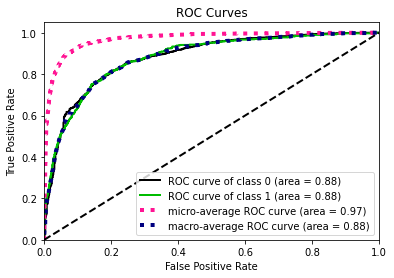

The Accuracy Ratio for sample 1 is: 76.05946720166337%


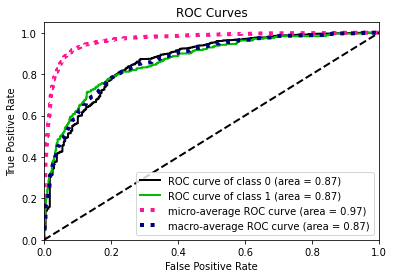

The Accuracy Ratio for sample 2 is: 72.82783083654141%


In [70]:
# calculate auc and AR
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import scikitplot as skplt

logit = LogisticRegression(max_iter=1000)
logit.fit(X_sample1, y_sample1)
y_probas = logit.predict_proba(X_sample1)
skplt.metrics.plot_roc(y_sample1, y_probas)
plt.show()

y_pred = result.predict(X_sample1)
auc = roc_auc_score(y_sample1, y_pred)
AR_sample1 = 2 * auc - 1
print('The Accuracy Ratio for sample 1 is: ' + str(AR_sample1*100) + '%')

logit = LogisticRegression(max_iter=1000)
logit.fit(X_sample2, y_sample2)
y_probas = logit.predict_proba(X_sample2)
skplt.metrics.plot_roc(y_sample2, y_probas)
plt.show()

y_pred = result.predict(X_sample2)
auc = roc_auc_score(y_sample2, y_pred)
AR_sample2 = 2 * auc - 1
print('The Accuracy Ratio for sample 2 is: ' + str(AR_sample2*100) + '%')

This is a good AR

In [71]:
# Lift at 10%
def lift_at_10pct(X,y):
    df_score_y = pd.concat([X, y], axis=1,sort=False)
    df_score_y = df_score_y.sort_values(by=['score_client'],ascending=True).copy()
    total_clients = len(df_score_y)
    clients_10pct = round(total_clients*0.1)
    default_pct = df_score_y['default_risk'].mean()
    lift_10pct = df_score_y.iloc[0:clients_10pct,1].sum() / clients_10pct / default_pct
    return lift_10pct
    
lift_10pct_sample1 = lift_at_10pct(X_score_sample1.iloc[:,0],y_sample1)
lift_10pct_sample2 = lift_at_10pct(X_score_sample2.iloc[:,0],y_sample2)
print('lift at 10% for sample1: ' + str(lift_10pct_sample1))
print('lift at 10% for sample2: ' + str(lift_10pct_sample2))

lift at 10% for sample1: 5.099100222959626
lift at 10% for sample2: 4.730053999928477


In [72]:
# Calculate population stability
value_count_sample1 = X_sample1_score_bin.value_counts(normalize=True).values
value_count_sample2 = X_sample2_score_bin.value_counts(normalize=True).values
pop_stability = pd.DataFrame(np.nan, index=range(len(value_count_sample1)), columns=('Score Range', 'Base', 'New','N-B','N/B','lnN/B', 'Index'))
pop_stability['Score Range'] = X_sample1_score_bin.value_counts(normalize=True).index.tolist()
pop_stability['Base'] = value_count_sample1 # base population
pop_stability['New'] = value_count_sample2  # new population
pop_stability['N-B'] = pop_stability['New'] - pop_stability['Base']
pop_stability['N/B'] = pop_stability['New'] / pop_stability['Base']
pop_stability['lnN/B'] = np.log2(pop_stability['N/B'])
pop_stability['Index'] = pop_stability['N-B'] * pop_stability['lnN/B']
psi = pop_stability['Index'].sum()

print('the PSI is: ' + str(psi))
pop_stability

the PSI is: 0.01505490796528127


,Score Range,Base,New,N-B,N/B,lnN/B,Index
0,"(>641,)",0.518772,0.505837,-0.012936,0.975064,-0.036430,0.000471
1,"(621-640,)",0.231146,0.209144,-0.022002,0.904814,-0.144308,0.003175
2,"(601-620,)",0.110349,0.124514,0.014164,1.128359,0.174226,0.002468
3,"(581-600,)",0.049625,0.065175,0.015551,1.313364,0.393267,0.006116
4,"(541-580,)",0.047339,0.056420,0.009081,1.191829,0.253177,0.002299
5,"(<540,)",0.042769,0.038911,-0.003858,0.909793,-0.136390,0.000526


Small PSI, no significant shift for the population over time

# Benchmark Model - Decision Tree

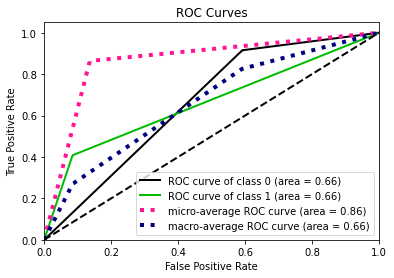

The Accuracy Ratio for sample 1 is: 32.16522220320157%


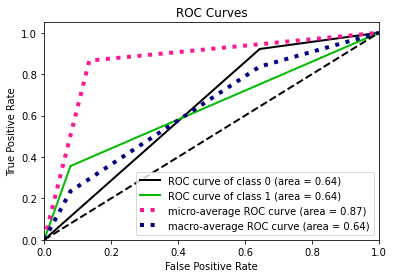

The Accuracy Ratio for sample 2 is: 27.83326327024298%


In [73]:
# Fit Decision Tree and get the prediction values
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# calculate auc and AR
clf = DecisionTreeClassifier()
clf = clf.fit(X_sample1,y_sample1)
y_probas = clf.predict_proba(X_sample2)
skplt.metrics.plot_roc(y_sample2, y_probas)
plt.show()

y_pred = clf.predict(X_sample2)
auc = roc_auc_score(y_sample2, y_pred)
AR_sample1 = 2 * auc - 1
print('The Accuracy Ratio for sample 1 is: ' + str(AR_sample1*100) + '%')

clf = DecisionTreeClassifier()
clf = clf.fit(X_sample2,y_sample2)
y_probas = clf.predict_proba(X_sample1)
skplt.metrics.plot_roc(y_sample1, y_probas)
plt.show()

y_pred = clf.predict(X_sample1)
auc = roc_auc_score(y_sample1, y_pred)
AR_sample2 = 2 * auc - 1
print('The Accuracy Ratio for sample 2 is: ' + str(AR_sample2*100) + '%')

In [74]:
# Set benchmark scores from dataset
benchmark_score = df_benchmark.iloc[:,0]
df_with_time = pd.concat([df_timekey, benchmark_score], axis=1,sort=False)
dates = pd.to_datetime([datetime.datetime(2014, 1, 1), datetime.datetime(2014, 4, 1), datetime.datetime(2014, 7, 1)])

df_sample1 = df_with_time.loc[df_with_time['TIME_KEY'].isin(dates)]
df_sample2 = df_with_time.loc[df_with_time['TIME_KEY'] == datetime.datetime(2014, 10, 1)]

X_score_sample1 = df_sample1.drop(['TIME_KEY'], axis=1)
X_score_sample2 = df_sample2.drop(['TIME_KEY'], axis=1)
X_score_sample1.reset_index(drop=True, inplace=True)
X_score_sample2.reset_index(drop=True, inplace=True)

In [75]:
X_score_sample1.describe()

,benchmark1
count,6671.000000
mean,771.834058
std,44.594800
min,582.000000
25%,749.000000
50%,779.000000
75%,804.000000
max,840.000000


In [76]:
# Bin the scorecard
X_sample1_score_bin = X_score_sample1.copy()
X_sample2_score_bin = X_score_sample2.copy()
bins = [0, 660, 700, 740, 780, 820, 1000]
labels = ['<660','661-700', '701-740','741-780','781-820','>820']
X_sample1_score_bin.iloc[:,0] = pd.cut(X_sample1_score_bin.iloc[:,0], bins=bins, labels=labels).copy()
X_sample2_score_bin.iloc[:,0] = pd.cut(X_sample2_score_bin.iloc[:,0], bins=bins, labels=labels).copy()

In [77]:
# Calculate KS
def KS_cal(df,y):
    cross = pd.crosstab(df, y)
    cross['non_default_pct'] = cross.iloc[:,0] / cross.iloc[:,0].sum()
    cross['default_pct'] = cross.iloc[:,1] / cross.iloc[:,1].sum()
    cross['cum_non_default_pct'] = cross['non_default_pct'].cumsum(axis = 0)
    cross['cum_default_pct'] = cross['default_pct'].cumsum(axis = 0)
    cross['KS'] = cross['cum_default_pct'] - cross['cum_non_default_pct']
    KS = max(cross['KS'])
    return cross, KS
    
cross_sample1, KS_sample1 = KS_cal(X_sample1_score_bin.iloc[:,0], y_sample1)
cross_sample2, KS_sample2 = KS_cal(X_sample2_score_bin.iloc[:,0], y_sample2)
print('KS_sample1 = ' + str(KS_sample1*100) + '%')
print('KS_sample2 = ' + str(KS_sample2*100) + '%')

KS_sample1 = 63.120240849215%
KS_sample2 = 61.09781877391127%


The biggiest KS corresponds to the score range of '701-740'

In [78]:
cross_sample2

default_risk,0,1,non_default_pct,default_pct,cum_non_default_pct,cum_default_pct,KS
benchmark1,,,,,,,
<660,15,42,0.007136,0.175732,0.007136,0.175732,0.168596
661-700,66,75,0.031399,0.313808,0.038535,0.489540,0.451005
701-740,253,67,0.120362,0.280335,0.158896,0.769874,0.610978
741-780,719,44,0.342055,0.184100,0.500951,0.953975,0.453023
781-820,777,9,0.369648,0.037657,0.870599,0.991632,0.121032
>820,272,2,0.129401,0.008368,1.000000,1.000000,0.000000


In [79]:
# Lift at 10%
def lift_at_10pct(X,y):
    df_score_y = pd.concat([X, y], axis=1,sort=False)
    df_score_y = df_score_y.sort_values(by=['benchmark1'],ascending=True).copy()
    total_clients = len(df_score_y)
    clients_10pct = round(total_clients*0.1)
    default_pct = df_score_y['default_risk'].mean()
    lift_10pct = df_score_y.iloc[0:clients_10pct,1].sum() / clients_10pct / default_pct
    return lift_10pct
    
lift_10pct_sample1 = lift_at_10pct(X_score_sample1.iloc[:,0],y_sample1)
lift_10pct_sample2 = lift_at_10pct(X_score_sample2.iloc[:,0],y_sample2)
print('lift at 10% for sample1: ' + str(lift_10pct_sample1))
print('lift at 10% for sample2: ' + str(lift_10pct_sample2))

lift at 10% for sample1: 5.356324863286965
lift at 10% for sample2: 5.483513929120624
